## **Imports**

The below code cell is used to import the necessary libraries for this project

In [2]:
import networkx as nx
import csv
import numpy as np 
import matplotlib.pyplot as plt
import statistics as sts
import random
import scipy.stats as stats
import math
import scipy.io as sio
import pickle 
from scipy.sparse import csr_matrix
from scipy import sparse
from multiprocessing import Pool

visualization for the literature review portion of the report

In [ ]:
mock = nx.dorogovtsev_goltsev_mendes_graph(4)

<function matplotlib.pyplot.show>

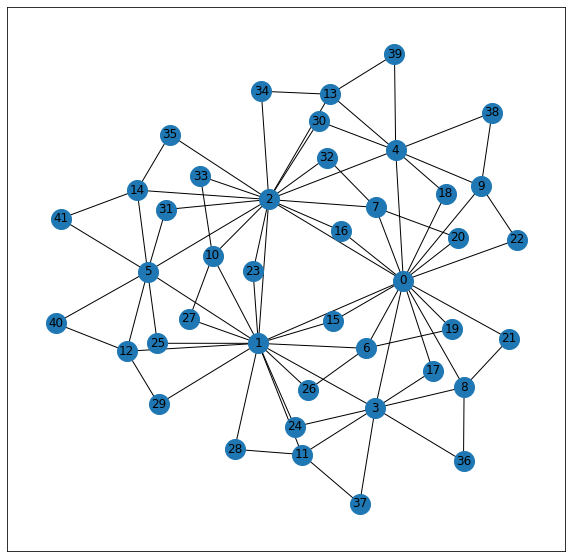

In [ ]:
#pos = nx.spring_layout(mock, k=0.15, iterations=10)
plt.figure(figsize=(10,10))
nx.draw_networkx(mock, node_size=400, font_size=12)
plt.show

<function matplotlib.pyplot.show>

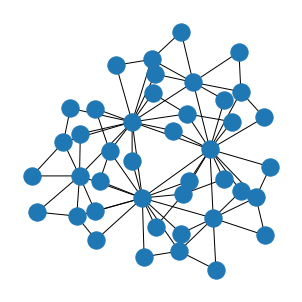

In [ ]:
plt.figure(figsize=(4,4))
nx.draw(kmock,node_size=300, font_size=12)
plt.show

## **Helper methods**

This method is used to import the graph data into a useable format for the subsequent alogorithms and experiments

In [3]:
def Import_graph_data(graph_data):  
  E = [] 
  with open(graph_data, 'r') as Graph: 
    graph_input = csv.reader(Graph, delimiter=' ')
    for row in graph_input: 
        if len(row) == 2: 
            E.append(row)
        elif len(row) == 3: 
          E.append(row[:2])
  G = nx.Graph()
  G.add_edges_from(E)
  G.remove_edges_from(nx.selfloop_edges(G))
  iso = nx.isolates(G)
  #G.remove_nodes_from(iso)
  return G

The method below is tasked with removing any non-connected components of the graph should there be any

In [4]:
def remove_unconnected(graph_data): 

  largest_component = max(nx.connected_components(graph_data), key=len)

  cleaned_graph = graph_data.subgraph(largest_component)

  return cleaned_graph

the method below is designed to deliver the statistics related to each graph, these statistics will be used when evaluating the effectiveness of the algorithms developed for this project. 

In [5]:
def statistics(G): 
  statistics = dict(); 

  statistics['Number of Nodes'] = G.number_of_nodes()
  statistics['Number of Edges'] = G.number_of_edges()
  statistics['Average Degree'] = (sum((dict(G.degree()).values())))/float(G.number_of_nodes())
  statistics['Density'] = nx.density(G)
  statistics['Clustering Coefficient'] = nx.average_clustering(G)
  statistics['Maximum K-core'] =  (sts.mean((nx.core_number(nx.k_core(G))).values()))

  return statistics


In [6]:
def core_number(G):
  nodes_list = G.nodes()
  core_number_graph = nx.core_number(G)
  core_number_graph = {n:core_number_graph[n] for n in nodes_list if n in core_number_graph}

  return core_number_graph

In [7]:
def supportNodes(instance , G , core_number_graph):

  equal_core = [n for n in G.neighbors(instance) if core_number_graph[n] == core_number_graph[instance]]
  greater_core = [n for n in G.neighbors(instance) if core_number_graph[n] > core_number_graph[instance]] 

  return equal_core, greater_core

In [8]:
def correlation(graph_one, graph_two, iter):
  ordered_nodes = sorted([graph_one[node] for node in graph_one], reverse=True)

  limit = 1 

  if iter < 100:
    limit = ordered_nodes[int(len(ordered_nodes) * iter/100)]

  one_filtered = {node:graph_one[node] for node in graph_one if node in graph_two}

  filtered = [node for node in one_filtered if one_filtered[node] > limit]

  value_one = [one_filtered[f] for f in filtered] + [0]
  value_two = [graph_two[f] for f in filtered] + [0]

  corr, _ = stats.kendalltau(value_one, value_two, nan_policy='omit')

  if np.isnan(corr): 
    corr = 1
  return corr

Method used to remove edges within the Edge Resilience method

In [9]:
def Edges(G, number_edges):
  E = list(G.edges())
  random.shuffle(E)
  deleted_edges = E[:number_edges]
  G.remove_edges_from(deleted_edges)
  return G

Method to remove nodes within the Node Resilience method

In [10]:
def Nodes(G, number_nodes): 
  nodes = list(G.nodes())
  random.shuffle(nodes)
  rnodes= nodes[:number_nodes]
  redges = []
  for u in rnodes:
    redges += list([(u,v) for v in G.neighbors(u)])
  G.remove_edges_from(redges)
	#graph.remove_nodes_from(rnodes)
  return G

## **Core Resilience**



In [11]:
def edge_resilience(G, limit, step_size, a = 0): 

  k = [50]
  Range = range(0,51,step_size)

  resilience = {} 

  for iter in k: 
    lower_limit = 0

    correlation_overall = []

    while lower_limit < limit: 
      Graph = Import_graph_data(G)
      number_edges = int(Graph.number_of_edges()*step_size/(100 * (1 + a/100)))

      original_core_number = core_number(Graph)

      correlation_values = []

      for r in Range: 

        Graph = Edges(Graph, number_edges)

        new_core_number = core_number(Graph)

        correlation_val = correlation(original_core_number, new_core_number, iter)

        correlation_val = correlation_val + (1-correlation_val)*a/100

        correlation_values.append(correlation_val)
      
      correlation_overall.append(np.mean(correlation_values))

      lower_limit += 1 
  resilience[iter] = (np.mean(correlation_overall))

  return resilience

In [12]:
def node_resilience(G, limit, step_size, a = 0): 

  k = [50]
  Range = range(0,51,step_size)

  resilience = {} 

  for iter in k: 
    lower_limit = 0

    correlation_overall = []

    while lower_limit < limit: 
      Graph = Import_graph_data(G)
      number_nodes = int(Graph.number_of_nodes()*step_size/(100 * (1 + a/100)))

      original_core_number = core_number(Graph)

      correlation_values = []

      for r in Range: 

        Graph = Nodes(Graph, number_nodes)

        new_core_number = core_number(Graph)

        correlation_val = correlation(original_core_number, new_core_number, iter)

        correlation_val = correlation_val + (1-correlation_val)*a/100

        correlation_values.append(correlation_val)
      
      correlation_overall.append(np.mean(correlation_values))

      lower_limit += 1 
  resilience[iter] = (np.mean(correlation_overall))

  return resilience

## **Core strength**

In [13]:
def CoreStrength(G, core_number_graph): 
  core_strength_result = {} 
  
  for core in core_number_graph:
    node_neighbors = G.neighbors(core) 
    delta = len([neighbor for neighbor in node_neighbors if core_number_graph[core] <= core_number_graph[neighbor]])
    core_strength_result[core] = delta - core_number_graph[core] + 1

  return core_strength_result

## **Core influence**

In [14]:
def CoreInfluence(G, core_number_graph): 
  
  all_nodes = [k for k in G.nodes() if core_number_graph[k] > 0]

  core_influence = {k:1.0 for k in all_nodes}
  core_dependence = {k:0 for k in all_nodes}

  #the following lines of code are used for assigning the values of the core 
  #number for each node as well as taking the max and minof these values
  
  core_number_list = [core_number_graph[k] for k in core_number_graph]
  maxi = max(core_number_list)
  mini = min(core_number_list)

  storage = []

  #the following lines of code are used for generating the K-core of the graph
  cores = set(core_number_graph.values())
  k_core_graph = {}
  for core in cores:
    k_core_graph[core] = nx.k_core(G, k = core, core_number=core_number_graph)

  for k in range(mini, maxi + 1): 

    if k not in k_core_graph: 
      continue 

    nodes_of_k_core = k_core_graph[k].nodes()
    nodes_of_k_core = [x for x in nodes_of_k_core if core_number_graph[x] == k]

    for n in set(nodes_of_k_core).intersection(all_nodes): 
      support_nodes , main_nodes = supportNodes(n , k_core_graph[k], core_number_graph)
			
      if len(support_nodes) >= core_number_graph[n]:
        core_dependence[n] = 1
        storage.append(n)
        continue
      else: 
        core_dependence[n] = 0

      intermediate = core_influence[n]*(core_number_graph[n] - len(support_nodes))/core_number_graph[n]
      share = intermediate/len(main_nodes)

      for nodes in main_nodes: 
        core_influence[nodes] += share

  return core_influence

## Core Influence strength

In [15]:
def CoreInfluenceStrength(core_influence_result, core_strength_result, percent): 


  tpv = np.percentile(list(core_influence_result.values()), percent)

  tpn = [node for node in core_influence_result if core_influence_result[node] > tpv]

  core_strength_tpn = [core_strength_result[node] for node in tpn]

  CIS = np.mean(core_strength_tpn)

  return CIS


# Data Preprocessing and Visualisation





This section serves to analyse and provide baseline measurements of the data sets as well as visualise the given metrics in a meaningful way which will be used in the report to explain the relationship between core influence strength and core resilience. 

 Tech-RL-caida Data

In [ ]:
caida_raw = "tech-RL-caida.mtx"
caida = Import_graph_data('tech-RL-caida.mtx')
core_caida= core_number(caida)
influence_caida = CoreInfluence(caida, core_caida)
strength_caida = CoreStrength(caida, core_caida)

caida_CIS = CoreInfluenceStrength(influence_caida, strength_caida, 95)
caida_node = node_resilience(caida_raw, 5, 5, 0)
caida_edge = edge_resilience(caida_raw, 5, 5, 0)
caida_stats = statistics(caida)


print("Node Resilience: ", caida_node)
print("Edge Resilience: ", caida_edge)
print("Core Influence Strength: ", caida_CIS)
print(caida_stats)

Node Resilience:  {50: 0.4664182305208572}
Edge Resilience:  {50: 0.7882131895786851}
Core Influence Strength:  3.7101403729310705
{'Number of Nodes': 190914, 'Number of Edges': 607610, 'Average Degree': 6.365274416753093, 'Density': 3.3341230910168995e-05, 'Clustering Coefficient': 0.15817334505180586, 'Maximum K-core': 32}


Tech-routers-rf

In [ ]:
tech_routers_raw = "tech-routers-rf.mtx"
tech = Import_graph_data('tech-routers-rf.mtx')
core_tech = core_number(tech)
influence_tech = CoreInfluence(tech, core_tech)
strength_tech = CoreStrength(tech, core_tech)

tech_CIS = CoreInfluenceStrength(influence_tech, strength_tech, 95)
tech_routers_node = node_resilience(tech_routers_raw, 5, 5, 0)
tech_routers_edge = edge_resilience(tech_routers_raw, 5, 5, 0)
tech_stats = statistics(tech)

print("Node Resilience: ", tech_routers_node)
print("Edge Resilience: ", tech_routers_edge)
print("Core Influence Strength: ", tech_CIS)
print(tech_stats)

Node Resilience:  {50: 0.48749284038508983}
Edge Resilience:  {50: 0.8304411175254185}
Core Influence Strength:  5.726415094339623
{'Number of Nodes': 2113, 'Number of Edges': 6632, 'Average Degree': 6.277330809275911, 'Density': 0.002972221027119276, 'Clustering Coefficient': 0.24642937534918363, 'Maximum K-core': 15}


Tech-WHOIS

In [ ]:
tech_who_raw = "tech-WHOIS.mtx"
tech_who = Import_graph_data('tech-WHOIS.mtx')
core_techW = core_number(tech_who)
influence_techW = CoreInfluence(tech_who, core_techW)
strength_techW = CoreStrength(tech_who, core_techW)

techW_CIS = CoreInfluenceStrength(influence_techW, strength_techW, 95)
tech_who_node = node_resilience(tech_who_raw, 5, 5, 0)
tech_who_edge = edge_resilience(tech_who_raw, 5, 5, 0)
techW_stats = statistics(tech_who)

print("Node Resilience: ", tech_who_node)
print("Edge Resilience: ", tech_who_edge)
print("Core Influence Strength: ", techW_CIS)
print(techW_stats)

Node Resilience:  {50: 0.5325743597266676}
Edge Resilience:  {50: 0.8994952731794875}
Core Influence Strength:  10.406417112299465
{'Number of Nodes': 7476, 'Number of Edges': 56943, 'Average Degree': 15.23354735152488, 'Density': 0.00203793275605684, 'Clustering Coefficient': 0.4889232938661372, 'Maximum K-core': 88}


Power-US-Grid

In [ ]:
power_US_raw = "power-US-Grid.mtx"
power_US = Import_graph_data('power-US-Grid.mtx')
core_powerUS = core_number(power_US)
influence_powerUS = CoreInfluence(power_US, core_powerUS)
strength_powerUS = CoreStrength(power_US, core_powerUS)

powerUS_CIS = CoreInfluenceStrength(influence_powerUS, strength_powerUS, 95)
power_US_node = node_resilience(power_US_raw, 5, 5, 0)
power_US_edge = edge_resilience(power_US_raw, 5, 5, 0)
powerUS_stats = statistics(power_US)

print("Node Resilience: ", power_US_node)
print("Edge Resilience: ", power_US_edge)
print("Core Influence Strength: ", powerUS_CIS)
print(powerUS_stats)

Node Resilience:  {50: 0.2399676244065468}
Edge Resilience:  {50: 0.4764733833825213}
Core Influence Strength:  2.3676470588235294
{'Number of Nodes': 4945, 'Number of Edges': 6597, 'Average Degree': 2.668149646107179, 'Density': 0.0005396742811705459, 'Clustering Coefficient': 0.0800388154406818, 'Maximum K-core': 5}


Power-bcspwr10

In [ ]:
power_BC_raw = "power-bcspwr10.mtx"
power_BC = Import_graph_data('power-bcspwr10.mtx')
core_powerBC = core_number(power_BC)
influence_powerBC = CoreInfluence(power_BC, core_powerBC)
strength_powerBC = CoreStrength(power_BC, core_powerBC)

powerBC_CIS = CoreInfluenceStrength(influence_powerBC, strength_powerBC, 95)
power_BC_node = node_resilience(power_BC_raw, 5, 5, 0)
power_BC_edge = edge_resilience(power_BC_raw, 5, 5, 0)
powerBC_stats = statistics(power_BC)

print("Node Resilience: ", power_BC_node)
print("Edge Resilience: ", power_BC_edge)
print("Core Influence Strength: ", powerBC_CIS)
print(powerBC_stats)

Node Resilience:  {50: 0.16578193212110462}
Edge Resilience:  {50: 0.3050003736756848}
Core Influence Strength:  1.9575289575289576
{'Number of Nodes': 5302, 'Number of Edges': 8272, 'Average Degree': 3.120331950207469, 'Density': 0.0005886308149797149, 'Clustering Coefficient': 0.08800205096885542, 'Maximum K-core': 4}


Power-eris1176

In [ ]:
power_E_raw = "power-eris1176.mtx"
power_E = Import_graph_data('power-eris1176.mtx')
core_powerE = core_number(power_E)
influence_powerE = CoreInfluence(power_E, core_powerE)
strength_powerE = CoreStrength(power_E, core_powerE)

powerE_CIS = CoreInfluenceStrength(influence_powerE, strength_powerE, 95)
power_E_node = node_resilience(power_E_raw, 5, 5, 0)
power_E_edge = edge_resilience(power_E_raw, 5, 5, 0)
powerE_stats = statistics(power_E)

print("Node Resilience: ", power_E_node)
print("Edge Resilience: ", power_E_edge)
print("Core Influence Strength: ", powerE_CIS)
print(powerE_stats)

Node Resilience:  {50: 0.5521232429477422}
Edge Resilience:  {50: 0.9570059686615513}
Core Influence Strength:  1.206896551724138
{'Number of Nodes': 1178, 'Number of Edges': 8689, 'Average Degree': 14.752122241086587, 'Density': 0.012533663756233295, 'Clustering Coefficient': 0.43122902884326497, 'Maximum K-core': 79}


**Visualisation of Edge Core Resilience vs Core Influence Strength**

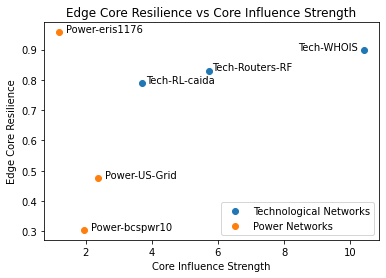

In [ ]:
core_influence_strength_tech = [3.7101, 5.7264, 10.4064]
edge_core_resilience_tech = [0.7882, 0.8304, 0.8995]

core_influence_strength_power = [2.3676, 1.9575, 1.2069]
edge_core_resilience_power = [ 0.4765, 0.3050, 0.9570]



plt.scatter(core_influence_strength_tech , edge_core_resilience_tech, label="Technological Networks")
plt.scatter(core_influence_strength_power, edge_core_resilience_power, label="Power Networks")
plt.title("Edge Core Resilience vs Core Influence Strength")
plt.xlabel("Core Influence Strength")
plt.ylabel("Edge Core Resilience")
plt.annotate("Tech-RL-caida", (3.8201,0.7882))
plt.annotate("Tech-Routers-RF", (5.8364,0.8304))
plt.annotate("Tech-WHOIS", (8.4164, 0.8995))
plt.annotate("Power-US-Grid", (2.5776, 0.4765))
plt.annotate("Power-bcspwr10", (2.1675 , 0.3050))
plt.annotate("Power-eris1176", (1.4169, 0.9570))
plt.legend()
plt.show()

Visualisation of Node Core Resilience vs Core Influence Strength

<function matplotlib.pyplot.show>

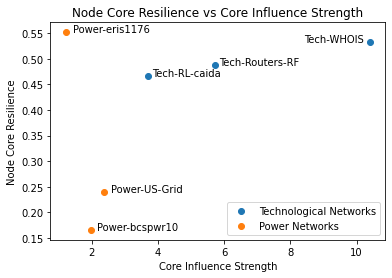

In [ ]:
core_influence_strength_tech = [3.7101, 5.7264, 10.4064]
node_core_resilience_tech = [0.4664, 0.4875, 0.5326,]

Core_influence_Strength_power = [2.3676, 1.9575, 1.2069] 
node_core_resilience_power = [ 0.2400, 0.1658, 0.5521]

plt.scatter(core_influence_strength_tech , node_core_resilience_tech, label="Technological Networks")
plt.scatter(core_influence_strength_power, node_core_resilience_power, label="Power Networks")
plt.title("Node Core Resilience vs Core Influence Strength")
plt.xlabel("Core Influence Strength")
plt.ylabel("Node Core Resilience")
plt.annotate("Tech-RL-caida", (3.8201, 0.4664))
plt.annotate("Tech-Routers-RF", (5.8364,0.4875))
plt.annotate("Tech-WHOIS", (8.4164, 0.5326))
plt.annotate("Power-US-Grid", (2.5776, 0.2400))
plt.annotate("Power-bcspwr10", (2.1675 , 0.1658))
plt.annotate("Power-eris1176", (1.4169, 0.5521))
plt.legend()
plt.show 

# Random Edge Addition Method

In [ ]:
def RandomEdge(G, Percentage): 

  edges = round(len(G.edges())*(Percentage/100))
  nodes = len(G.nodes)
  list_of_nodes = list(G.nodes())
  middle = math.floor(nodes/2)
  first = list_of_nodes[:middle]
  second = list_of_nodes[middle:]
  
  for i in range(1, edges+1): 

    randomOne = random.choice(first)

    randomTwo = random.choice(second)
    
    if G.has_edge(randomOne, randomTwo): 
      i -= 1
      continue
    else: 
      G.add_edge(randomOne, randomTwo)

  return G

## Random Edge Addition Results

Tech-RL-caida

In [ ]:
#Adding 1% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_one = RandomEdge(caida, 1)

nx.write_edgelist(caida_one, "caida_one.mtx")
caida_raw_one = "caida_one.mtx"

core_caida_one = core_number(caida_one)
influence_caida_one = CoreInfluence(caida_one, core_caida_one)
strength_caida_one = CoreStrength(caida_one, core_caida_one)

caida_CIS_one = CoreInfluenceStrength(influence_caida_one, strength_caida_one, 95)
caida_node_one = node_resilience(caida_raw_one, 5, 5, 0)
caida_edge_one = edge_resilience(caida_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_two = RandomEdge(caida, 2)

nx.write_edgelist(caida_two, "caida_two.mtx")
caida_raw_two = "caida_two.mtx"

core_caida_two = core_number(caida_two)
influence_caida_two = CoreInfluence(caida_two, core_caida_two)
strength_caida_two = CoreStrength(caida_two, core_caida_two)

caida_CIS_two = CoreInfluenceStrength(influence_caida_two, strength_caida_two, 95)
caida_node_two = node_resilience(caida_raw_two, 5, 5, 0)
caida_edge_two = edge_resilience(caida_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_three = RandomEdge(caida, 3)

nx.write_edgelist(caida_three, "caida_three.mtx")
caida_raw_three = "caida_three.mtx"

core_caida_three = core_number(caida_three)
influence_caida_three = CoreInfluence(caida_three, core_caida_three)
strength_caida_three = CoreStrength(caida_three, core_caida_three)

caida_CIS_three = CoreInfluenceStrength(influence_caida_three, strength_caida_three, 95)
caida_node_three = node_resilience(caida_raw_three, 5, 5, 0)
caida_edge_three = edge_resilience(caida_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_four = RandomEdge(caida, 4)

nx.write_edgelist(caida_four, "caida_four.mtx")
caida_raw_four = "caida_four.mtx"

core_caida_four = core_number(caida_four)
influence_caida_four = CoreInfluence(caida_four, core_caida_four)
strength_caida_four = CoreStrength(caida_four, core_caida_four)

caida_CIS_four = CoreInfluenceStrength(influence_caida_four, strength_caida_four, 95)
caida_node_four = node_resilience(caida_raw_four, 5, 5, 0)
caida_edge_four = edge_resilience(caida_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_five = RandomEdge(caida, 5)

nx.write_edgelist(caida_five, "caida_five.mtx")
caida_raw_five = "caida_five.mtx"

core_caida_five = core_number(caida_five)
influence_caida_five = CoreInfluence(caida_five, core_caida_five)
strength_caida_five = CoreStrength(caida_five, core_caida_five)

caida_CIS_five = CoreInfluenceStrength(influence_caida_five, strength_caida_five, 95)
caida_node_five = node_resilience(caida_raw_five, 5, 5, 0)
caida_edge_five = edge_resilience(caida_raw_five, 5, 5, 0)

In [ ]:
print(statistics(caida_one))
print(statistics(caida_two))
print(statistics(caida_three))
print(statistics(caida_four))
print(statistics(caida_five))

{'Number of Nodes': 190914, 'Number of Edges': 613685, 'Average Degree': 6.428915637407419, 'Density': 3.367458285924698e-05, 'Clustering Coefficient': 0.15374017266110215, 'Maximum K-core': 32}
{'Number of Nodes': 190914, 'Number of Edges': 619762, 'Average Degree': 6.492577809903936, 'Density': 3.400804455382261e-05, 'Clustering Coefficient': 0.149573506530841, 'Maximum K-core': 32}
{'Number of Nodes': 190914, 'Number of Edges': 625838, 'Average Degree': 6.556229506479357, 'Density': 3.434145137564942e-05, 'Clustering Coefficient': 0.14574976507382556, 'Maximum K-core': 32}
{'Number of Nodes': 190914, 'Number of Edges': 631914, 'Average Degree': 6.619881203054779, 'Density': 3.4674858197476225e-05, 'Clustering Coefficient': 0.14159654036667743, 'Maximum K-core': 32}
{'Number of Nodes': 190914, 'Number of Edges': 637990, 'Average Degree': 6.6835328996302, 'Density': 3.500826501930303e-05, 'Clustering Coefficient': 0.13773436704556716, 'Maximum K-core': 32}


In [ ]:
print("Core Influence Strength: 1%: ", caida_CIS_one, " 2%: ", caida_CIS_two, " 3%: ", caida_CIS_three, " 4%: ", caida_CIS_four , " 5%: ", caida_CIS_five )
print("Node Resilience: 1%: ", caida_node_one, " 2%: ", caida_node_two, " 3%: ", caida_node_three, " 4%: ", caida_node_four , " 5%: ",  caida_node_five)
print("Edge Resilience: 1%: ", caida_edge_one, " 2%: ", caida_edge_two, " 3%: ", caida_edge_three, " 4%: ", caida_edge_four , " 5%: ",  caida_edge_five)

Core Influence Strength: 1%:  3.720511208883302  2%:  3.7448145820238845  3%:  3.7764508694741252  4%:  3.761785040854808  5%:  3.780069819105046
Node Resilience: 1%:  {50: 0.4634409009627494}  2%:  {50: 0.46579159561572914}  3%:  {50: 0.45986879504923256}  4%:  {50: 0.4604303843340496}  5%:  {50: 0.45895658053936206}
Edge Resilience: 1%:  {50: 0.7866173565396457}  2%:  {50: 0.7868612669014747}  3%:  {50: 0.788250534185041}  4%:  {50: 0.786979709812804}  5%:  {50: 0.7872332458438531}


Tech-routers-rf

In [ ]:
# Adding 1% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_one = RandomEdge(tech_routers, 1)

nx.write_edgelist(tech_one, "tech_one.mtx")
tech_routers_raw_one = "tech_one.mtx"

core_tech_one = core_number(tech_one)
influence_tech_one = CoreInfluence(tech_one, core_tech_one)
strength_tech_one = CoreStrength(tech_one, core_tech_one)

tech_CIS_one = CoreInfluenceStrength(influence_tech_one, strength_tech_one, 95)
tech_routers_node_one = node_resilience(tech_routers_raw_one, 5, 5, 0)
tech_routers_edge_one = edge_resilience(tech_routers_raw_one, 5, 5, 0)

# Adding 2% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_two = RandomEdge(tech_routers, 2)

nx.write_edgelist(tech_two, "tech_two.mtx")
tech_routers_raw_two = "tech_two.mtx"

core_tech_two = core_number(tech_two)
influence_tech_two = CoreInfluence(tech_two, core_tech_two)
strength_tech_two = CoreStrength(tech_two, core_tech_two)

tech_CIS_two = CoreInfluenceStrength(influence_tech_two, strength_tech_two, 95)
tech_routers_node_two = node_resilience(tech_routers_raw_two, 5, 5, 0)
tech_routers_edge_two = edge_resilience(tech_routers_raw_two, 5, 5, 0)

# Adding 3% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_three = RandomEdge(tech_routers, 3)

nx.write_edgelist(tech_three, "tech_three.mtx")
tech_routers_raw_three = "tech_three.mtx"

core_tech_three = core_number(tech_three)
influence_tech_three = CoreInfluence(tech_three, core_tech_three)
strength_tech_three = CoreStrength(tech_three, core_tech_three)

tech_CIS_three = CoreInfluenceStrength(influence_tech_three, strength_tech_three, 95)
tech_routers_node_three = node_resilience(tech_routers_raw_three, 5, 5, 0)
tech_routers_edge_three = edge_resilience(tech_routers_raw_three, 5, 5, 0)

#adding 4% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_four = RandomEdge(tech_routers, 4)

nx.write_edgelist(tech_four, "tech_four.mtx")
tech_routers_raw_four = "tech_four.mtx"

core_tech_four = core_number(tech_four)
influence_tech_four = CoreInfluence(tech_four, core_tech_four)
strength_tech_four = CoreStrength(tech_four, core_tech_four)

tech_CIS_four = CoreInfluenceStrength(influence_tech_four, strength_tech_four, 95)
tech_routers_node_four = node_resilience(tech_routers_raw_four, 5, 5, 0)
tech_routers_edge_four = edge_resilience(tech_routers_raw_four, 5, 5, 0)

#adding 5% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_five = RandomEdge(tech_routers, 5)

nx.write_edgelist(tech_five, "tech_five.mtx")
tech_routers_raw_five = "tech_five.mtx"

core_tech_five = core_number(tech_five)
influence_tech_five = CoreInfluence(tech_five, core_tech_five)
strength_tech_five = CoreStrength(tech_five, core_tech_five)

tech_CIS_five = CoreInfluenceStrength(influence_tech_five, strength_tech_five, 95)
tech_routers_node_five = node_resilience(tech_routers_raw_five, 5, 5, 0)
tech_routers_edge_five = edge_resilience(tech_routers_raw_five, 5, 5, 0)

In [ ]:
print(statistics(tech_one))
print(statistics(tech_two))
print(statistics(tech_three))
print(statistics(tech_four))
print(statistics(tech_five))

{'Number of Nodes': 2113, 'Number of Edges': 6698, 'Average Degree': 6.339801230477994, 'Density': 0.003001799825036929, 'Clustering Coefficient': 0.24079829376374146, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6765, 'Average Degree': 6.403218173213441, 'Density': 0.003031826786559394, 'Clustering Coefficient': 0.2347983117479729, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6831, 'Average Degree': 6.465688594415523, 'Density': 0.0030614055844770467, 'Clustering Coefficient': 0.22905734671942965, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6896, 'Average Degree': 6.527212494084241, 'Density': 0.0030905362187898864, 'Clustering Coefficient': 0.22194255205770738, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6964, 'Average Degree': 6.591575958353053, 'Density': 0.003121011343917165, 'Clustering Coefficient': 0.22092820669629937, 'Maximum K-core': 15}


In [ ]:
print("Core Influence Strength: 1%: ", tech_CIS_one, " 2%: ", tech_CIS_two, " 3%: ", tech_CIS_three, " 4%: ", tech_CIS_four , " 5%: ", tech_CIS_five )
print("Node Resilience: 1%: ", tech_routers_node_one, " 2%: ", tech_routers_node_two, " 3%: ", tech_routers_node_three, " 4%: ", tech_routers_node_four, " 5%: ",  tech_routers_node_five)
print("Edge Resilience: 1%: ", tech_routers_edge_one, " 2%: ", tech_routers_edge_two, " 3%: ", tech_routers_edge_three, " 4%: ", tech_routers_edge_four , " 5%: ",  tech_routers_edge_five)

Core Influence Strength: 1%:  5.679245283018868  2%:  5.752380952380952  3%:  5.933962264150943  4%:  5.9245283018867925  5%:  5.830188679245283
Node Resilience: 1%:  {50: 0.4962660549580379}  2%:  {50: 0.5166917358531096}  3%:  {50: 0.4957738300887784}  4%:  {50: 0.46921337048840595}  5%:  {50: 0.4840285106228556}
Edge Resilience: 1%:  {50: 0.8318687971980779}  2%:  {50: 0.8292189703992957}  3%:  {50: 0.8259649679036698}  4%:  {50: 0.827991743603121}  5%:  {50: 0.8197592110106136}


Tech-WHOIS

In [ ]:
#Adding 1% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_one = RandomEdge(tech_who, 1)

nx.write_edgelist(techW_one, "techW_one.mtx")
tech_who_raw_one = "techW_one.mtx"

core_techW_one = core_number(techW_one)
influence_techW_one = CoreInfluence(techW_one, core_techW_one)
strength_techW_one = CoreStrength(techW_one, core_techW_one)

techW_CIS_one = CoreInfluenceStrength(influence_techW_one, strength_techW_one, 95)
tech_who_node_one = node_resilience(tech_who_raw_one, 5, 5, 0)
tech_who_edge_one = edge_resilience(tech_who_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_two = RandomEdge(tech_who, 2)

nx.write_edgelist(techW_two, "techW_two.mtx")
tech_who_raw_two = "techW_two.mtx"

core_techW_two = core_number(techW_two)
influence_techW_two = CoreInfluence(techW_two, core_techW_two)
strength_techW_two = CoreStrength(techW_two, core_techW_two)

techW_CIS_two = CoreInfluenceStrength(influence_techW_two, strength_techW_two, 95)
tech_who_node_two = node_resilience(tech_who_raw_two, 5, 5, 0)
tech_who_edge_two = edge_resilience(tech_who_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_three = RandomEdge(tech_who, 3)

nx.write_edgelist(techW_three, "techW_three.mtx")
tech_who_raw_three = "techW_three.mtx"

core_techW_three = core_number(techW_three)
influence_techW_three = CoreInfluence(techW_three, core_techW_three)
strength_techW_three = CoreStrength(techW_three, core_techW_three)

techW_CIS_three = CoreInfluenceStrength(influence_techW_three, strength_techW_three, 95)
tech_who_node_three = node_resilience(tech_who_raw_three, 5, 5, 0)
tech_who_edge_three = edge_resilience(tech_who_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_four = RandomEdge(tech_who, 4)

nx.write_edgelist(techW_four, "techW_four.mtx")
tech_who_raw_four = "techW_four.mtx"

core_techW_four = core_number(techW_four)
influence_techW_four = CoreInfluence(techW_four, core_techW_four)
strength_techW_four = CoreStrength(techW_four, core_techW_four)

techW_CIS_four = CoreInfluenceStrength(influence_techW_four, strength_techW_four, 95)
tech_who_node_four = node_resilience(tech_who_raw_four, 5, 5, 0)
tech_who_edge_four = edge_resilience(tech_who_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_five = RandomEdge(tech_who, 5)

nx.write_edgelist(techW_five, "techW_five.mtx")
tech_who_raw_five = "techW_five.mtx"

core_techW_five = core_number(techW_five)
influence_techW_five = CoreInfluence(techW_five, core_techW_five)
strength_techW_five = CoreStrength(techW_five, core_techW_five)

techW_CIS_five = CoreInfluenceStrength(influence_techW_five, strength_techW_five, 95)
tech_who_node_five = node_resilience(tech_who_raw_five, 5, 5, 0)
tech_who_edge_five = edge_resilience(tech_who_raw_five, 5, 5, 0)

In [ ]:
print(statistics(techW_one))
print(statistics(techW_two))
print(statistics(techW_three))
print(statistics(techW_four))
print(statistics(techW_five))

{'Number of Nodes': 7476, 'Number of Edges': 57512, 'Average Degree': 15.385767790262172, 'Density': 0.0020582966943494545, 'Clustering Coefficient': 0.4562631744210889, 'Maximum K-core': 88}
{'Number of Nodes': 7476, 'Number of Edges': 58078, 'Average Degree': 15.537185660781166, 'Density': 0.002078553265656343, 'Clustering Coefficient': 0.42936156560950006, 'Maximum K-core': 88}
{'Number of Nodes': 7476, 'Number of Edges': 58650, 'Average Degree': 15.690208667736758, 'Density': 0.0020990245709346833, 'Clustering Coefficient': 0.40347366284831726, 'Maximum K-core': 88}
{'Number of Nodes': 7476, 'Number of Edges': 59219, 'Average Degree': 15.84242910647405, 'Density': 0.0021193885092272977, 'Clustering Coefficient': 0.37637044190323016, 'Maximum K-core': 88}
{'Number of Nodes': 7476, 'Number of Edges': 59789, 'Average Degree': 15.994917067950777, 'Density': 0.002139788236515154, 'Clustering Coefficient': 0.35598579951162673, 'Maximum K-core': 88}


In [ ]:
print("Core Influence Strength: 1%: ", techW_CIS_one, " 2%: ", techW_CIS_two, " 3%: ", techW_CIS_three, " 4%: ", techW_CIS_four , " 5%: ", techW_CIS_five )
print("Node Resilience: 1%: ", tech_who_node_one, " 2%: ", tech_who_node_two, " 3%: ", tech_who_node_three, " 4%: ", tech_who_node_four, " 5%: ",  tech_who_node_five)
print("Edge Resilience: 1%: ", tech_who_edge_one, " 2%: ", tech_who_edge_two, " 3%: ", tech_who_edge_three, " 4%: ", tech_who_edge_four , " 5%: ",  tech_who_edge_five)

Core Influence Strength: 1%:  10.582887700534759  2%:  10.497326203208557  3%:  10.553475935828876  4%:  10.256684491978609  5%:  10.497326203208557
Node Resilience: 1%:  {50: 0.5375557831290976}  2%:  {50: 0.5169232329052826}  3%:  {50: 0.5075868017498891}  4%:  {50: 0.510697479760314}  5%:  {50: 0.5105484327178091}
Edge Resilience: 1%:  {50: 0.894575411528615}  2%:  {50: 0.8825113341210151}  3%:  {50: 0.8732545156621543}  4%:  {50: 0.8644944496643051}  5%:  {50: 0.8572465645605465}


Power-US-Grid

In [ ]:
#Adding 1% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_one = RandomEdge(power_US, 1)

nx.write_edgelist(power_US_one, "power_US_one.mtx")
power_US_raw_one = "power_US_one.mtx"

core_powerUS_one = core_number(power_US_one)
influence_powerUS_one = CoreInfluence(power_US_one, core_powerUS_one)
strength_powerUS_one = CoreStrength(power_US_one, core_powerUS_one)

powerUS_CIS_one = CoreInfluenceStrength(influence_powerUS_one, strength_powerUS_one, 95)
power_US_node_one = node_resilience(power_US_raw_one, 5, 5, 0)
power_US_edge_one = edge_resilience(power_US_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_two = RandomEdge(power_US, 2)

nx.write_edgelist(power_US_two, "power_US_two.mtx")
power_US_raw_two = "power_US_two.mtx"

core_powerUS_two = core_number(power_US_two)
influence_powerUS_two = CoreInfluence(power_US_two, core_powerUS_two)
strength_powerUS_two = CoreStrength(power_US_two, core_powerUS_two)

powerUS_CIS_two = CoreInfluenceStrength(influence_powerUS_two, strength_powerUS_two, 95)
power_US_node_two = node_resilience(power_US_raw_two, 5, 5, 0)
power_US_edge_two = edge_resilience(power_US_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_three = RandomEdge(power_US, 3)

nx.write_edgelist(power_US_three, "power_US_three.mtx")
power_US_raw_three = "power_US_three.mtx"

core_powerUS_three = core_number(power_US_three)
influence_powerUS_three = CoreInfluence(power_US_three, core_powerUS_three)
strength_powerUS_three = CoreStrength(power_US_three, core_powerUS_three)

powerUS_CIS_three = CoreInfluenceStrength(influence_powerUS_three, strength_powerUS_three, 95)
power_US_node_three = node_resilience(power_US_raw_three, 5, 5, 0)
power_US_edge_three = edge_resilience(power_US_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_four = RandomEdge(power_US, 4)

nx.write_edgelist(power_US_four, "power_US_four.mtx")
power_US_raw_four = "power_US_four.mtx"

core_powerUS_four = core_number(power_US_four)
influence_powerUS_four = CoreInfluence(power_US_four, core_powerUS_four)
strength_powerUS_four = CoreStrength(power_US_four, core_powerUS_four)

powerUS_CIS_four = CoreInfluenceStrength(influence_powerUS_four, strength_powerUS_four, 95)
power_US_node_four = node_resilience(power_US_raw_four, 5, 5, 0)
power_US_edge_four = edge_resilience(power_US_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_five = RandomEdge(power_US, 5)

nx.write_edgelist(power_US_five, "power_US_five.mtx")
power_US_raw_five = "power_US_five.mtx"

core_powerUS_five = core_number(power_US_five)
influence_powerUS_five = CoreInfluence(power_US_five, core_powerUS_five)
strength_powerUS_five = CoreStrength(power_US_five, core_powerUS_five)

powerUS_CIS_five = CoreInfluenceStrength(influence_powerUS_five, strength_powerUS_five, 95)
power_US_node_five = node_resilience(power_US_raw_five, 5, 5, 0)
power_US_edge_five = edge_resilience(power_US_raw_five, 5, 5, 0)


In [ ]:
print(statistics(power_US_one))
print(statistics(power_US_two))
print(statistics(power_US_three))
print(statistics(power_US_four))
print(statistics(power_US_five))

{'Number of Nodes': 4948, 'Number of Edges': 6666, 'Average Degree': 2.6944219886822958, 'Density': 0.000544657770099514, 'Clustering Coefficient': 0.07920337339541644, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6732, 'Average Degree': 2.721099434114794, 'Density': 0.0005500504212886181, 'Clustering Coefficient': 0.07832615508691279, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6798, 'Average Degree': 2.747776879547292, 'Density': 0.0005554430724777223, 'Clustering Coefficient': 0.07685427634138815, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6864, 'Average Degree': 2.7744543249797897, 'Density': 0.0005608357236668263, 'Clustering Coefficient': 0.07634708906176753, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6930, 'Average Degree': 2.801131770412288, 'Density': 0.0005662283748559304, 'Clustering Coefficient': 0.0752799411591093, 'Maximum K-core': 5}


In [ ]:
print("Core Influence Strength: 1%: ", powerUS_CIS_one, " 2%: ", powerUS_CIS_two, " 3%: ", powerUS_CIS_three, " 4%: ", powerUS_CIS_four , " 5%: ", powerUS_CIS_five )
print("Node Resilience: 1%: ", power_US_node_one, " 2%: ", power_US_node_two, " 3%: ", power_US_node_three, " 4%: ", power_US_node_four, " 5%: ",  power_US_node_five)
print("Edge Resilience: 1%: ", power_US_edge_one, " 2%: ", power_US_edge_two, " 3%: ", power_US_edge_three, " 4%: ", power_US_edge_four , " 5%: ",  power_US_edge_five)

Core Influence Strength: 1%:  2.3891625615763545  2%:  2.4461538461538463  3%:  2.4031413612565444  4%:  2.417525773195876  5%:  2.435
Node Resilience: 1%:  {50: 0.26524677801443874}  2%:  {50: 0.25168203712391424}  3%:  {50: 0.2846493232909915}  4%:  {50: 0.3046336687384742}  5%:  {50: 0.3018558578329431}
Edge Resilience: 1%:  {50: 0.4817509850051085}  2%:  {50: 0.4572094931882402}  3%:  {50: 0.5031976721099777}  4%:  {50: 0.49785183635540253}  5%:  {50: 0.45012378304771505}


Power-bcspwr10

In [ ]:
#Adding 1% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_one = RandomEdge(power_BC, 1)

nx.write_edgelist(power_BC_one, "power_BC_one.mtx")
power_BC_raw_one = "power_BC_one.mtx"

core_powerBC_one = core_number(power_BC_one)
influence_powerBC_one = CoreInfluence(power_BC_one, core_powerBC_one)
strength_powerBC_one = CoreStrength(power_BC_one, core_powerBC_one)

powerBC_CIS_one = CoreInfluenceStrength(influence_powerBC_one, strength_powerBC_one, 95)
power_BC_node_one = node_resilience(power_BC_raw_one, 5, 5, 0)
power_BC_edge_one = edge_resilience(power_BC_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_two = RandomEdge(power_BC, 2)

nx.write_edgelist(power_BC_two, "power_BC_two.mtx")
power_BC_raw_two = "power_BC_two.mtx"

core_powerBC_two = core_number(power_BC_two)
influence_powerBC_two = CoreInfluence(power_BC_two, core_powerBC_two)
strength_powerBC_two = CoreStrength(power_BC_two, core_powerBC_two)

powerBC_CIS_two = CoreInfluenceStrength(influence_powerBC_two, strength_powerBC_two, 95)
power_BC_node_two = node_resilience(power_BC_raw_two, 5, 5, 0)
power_BC_edge_two = edge_resilience(power_BC_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_three = RandomEdge(power_BC, 3)

nx.write_edgelist(power_BC_three, "power_BC_three.mtx")
power_BC_raw_three = "power_BC_three.mtx"

core_powerBC_three = core_number(power_BC_three)
influence_powerBC_three = CoreInfluence(power_BC_three, core_powerBC_three)
strength_powerBC_three = CoreStrength(power_BC_three, core_powerBC_three)

powerBC_CIS_three = CoreInfluenceStrength(influence_powerBC_three, strength_powerBC_three, 95)
power_BC_node_three = node_resilience(power_BC_raw_three, 5, 5, 0)
power_BC_edge_three = edge_resilience(power_BC_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_four = RandomEdge(power_BC, 4)

nx.write_edgelist(power_BC_four, "power_BC_four.mtx")
power_BC_raw_four = "power_BC_four.mtx"

core_powerBC_four = core_number(power_BC_four)
influence_powerBC_four = CoreInfluence(power_BC_four, core_powerBC_four)
strength_powerBC_four = CoreStrength(power_BC_four, core_powerBC_four)

powerBC_CIS_four = CoreInfluenceStrength(influence_powerBC_four, strength_powerBC_four, 95)
power_BC_node_four = node_resilience(power_BC_raw_four, 5, 5, 0)
power_BC_edge_four = edge_resilience(power_BC_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_five = RandomEdge(power_BC, 5)

nx.write_edgelist(power_BC_five, "power_BC_five.mtx")
power_BC_raw_five = "power_BC_five.mtx"

core_powerBC_five = core_number(power_BC_five)
influence_powerBC_five = CoreInfluence(power_BC_five, core_powerBC_five)
strength_powerBC_five = CoreStrength(power_BC_five, core_powerBC_five)

powerBC_CIS_five = CoreInfluenceStrength(influence_powerBC_five, strength_powerBC_five, 95)
power_BC_node_five = node_resilience(power_BC_raw_five, 5, 5, 0)
power_BC_edge_five = edge_resilience(power_BC_raw_five, 5, 5, 0)

In [ ]:
print(statistics(power_BC_one))
print(statistics(power_BC_two))
print(statistics(power_BC_three))
print(statistics(power_BC_four))
print(statistics(power_BC_five))

{'Number of Nodes': 5305, 'Number of Edges': 8358, 'Average Degree': 3.150989632422243, 'Density': 0.0005940779849966522, 'Clustering Coefficient': 0.08639310945625704, 'Maximum K-core': 4}
{'Number of Nodes': 5305, 'Number of Edges': 8441, 'Average Degree': 3.1822808671065035, 'Density': 0.0005999775390472292, 'Clustering Coefficient': 0.08564062704496218, 'Maximum K-core': 4}
{'Number of Nodes': 5305, 'Number of Edges': 8523, 'Average Degree': 3.2131950989632423, 'Density': 0.0006058060141333413, 'Clustering Coefficient': 0.08388540143488266, 'Maximum K-core': 4}
{'Number of Nodes': 5305, 'Number of Edges': 8605, 'Average Degree': 3.244109330819981, 'Density': 0.0006116344892194535, 'Clustering Coefficient': 0.08194507450869337, 'Maximum K-core': 4}
{'Number of Nodes': 5305, 'Number of Edges': 8688, 'Average Degree': 3.275400565504241, 'Density': 0.0006175340432700304, 'Clustering Coefficient': 0.08071957051221872, 'Maximum K-core': 4}


In [ ]:
print("Core Influence Strength: 1%: ", powerBC_CIS_one, " 2%: ", powerBC_CIS_two, " 3%: ", powerBC_CIS_three, " 4%: ", powerBC_CIS_four , " 5%: ", powerBC_CIS_five )
print("Node Resilience: 1%: ", power_BC_node_one, " 2%: ", power_BC_node_two, " 3%: ", power_BC_node_three, " 4%: ", power_BC_node_four, " 5%: ",  power_BC_node_five)
print("Edge Resilience: 1%: ", power_BC_edge_one, " 2%: ", power_BC_edge_two, " 3%: ", power_BC_edge_three, " 4%: ", power_BC_edge_four , " 5%: ",  power_BC_edge_five)

Core Influence Strength: 1%:  1.9446640316205535  2%:  2.027027027027027  3%:  2.007751937984496  4%:  1.9960474308300395  5%:  2.0539419087136928
Node Resilience: 1%:  {50: 0.18725739602765082}  2%:  {50: 0.20556668625706015}  3%:  {50: 0.15078341035399376}  4%:  {50: 0.21667417705389927}  5%:  {50: 0.23161230128414348}
Edge Resilience: 1%:  {50: 0.2503826583752814}  2%:  {50: 0.30018102755885423}  3%:  {50: 0.3315836410481991}  4%:  {50: 0.27786339381061553}  5%:  {50: 0.20487453961714824}


Power-eris1176

In [ ]:
#Adding 1% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_one = RandomEdge(power_E, 1)

nx.write_edgelist(power_E_one, "power_E_one.mtx")
power_E_raw_one = "power_E_one.mtx"

core_powerE_one = core_number(power_E_one)
influence_powerE_one = CoreInfluence(power_E_one, core_powerE_one)
strength_powerE_one = CoreStrength(power_E_one, core_powerE_one)

powerE_CIS_one = CoreInfluenceStrength(influence_powerE_one, strength_powerE_one, 95)
power_E_node_one = node_resilience(power_E_raw_one, 5, 5, 0)
power_E_edge_one = edge_resilience(power_E_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_two = RandomEdge(power_E, 2)

nx.write_edgelist(power_E_two, "power_E_two.mtx")
power_E_raw_two = "power_E_two.mtx"

core_powerE_two = core_number(power_E_two)
influence_powerE_two = CoreInfluence(power_E_two, core_powerE_two)
strength_powerE_two = CoreStrength(power_E_two, core_powerE_two)

powerE_CIS_two = CoreInfluenceStrength(influence_powerE_two, strength_powerE_two, 95)
power_E_node_two = node_resilience(power_E_raw_two, 5, 5, 0)
power_E_edge_two = edge_resilience(power_E_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_three = RandomEdge(power_E, 3)

nx.write_edgelist(power_E_three, "power_E_three.mtx")
power_E_raw_three = "power_E_three.mtx"

core_powerE_three = core_number(power_E_three)
influence_powerE_three = CoreInfluence(power_E_three, core_powerE_three)
strength_powerE_three = CoreStrength(power_E_three, core_powerE_three)

powerE_CIS_three = CoreInfluenceStrength(influence_powerE_three, strength_powerE_three, 95)
power_E_node_three = node_resilience(power_E_raw_three, 5, 5, 0)
power_E_edge_three = edge_resilience(power_E_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_four = RandomEdge(power_E, 4)

nx.write_edgelist(power_E_four, "power_E_four.mtx")
power_E_raw_four = "power_E_four.mtx"

core_powerE_four = core_number(power_E_four)
influence_powerE_four = CoreInfluence(power_E_four, core_powerE_four)
strength_powerE_four = CoreStrength(power_E_four, core_powerE_four)

powerE_CIS_four = CoreInfluenceStrength(influence_powerE_four, strength_powerE_four, 95)
power_E_node_four = node_resilience(power_E_raw_four, 5, 5, 0)
power_E_edge_four = edge_resilience(power_E_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_five = RandomEdge(power_E, 5)

nx.write_edgelist(power_E_five, "power_E_five.mtx")
power_E_raw_five = "power_E_five.mtx"

core_powerE_five = core_number(power_E_five)
influence_powerE_five = CoreInfluence(power_E_five, core_powerE_five)
strength_powerE_five = CoreStrength(power_E_five, core_powerE_five)

powerE_CIS_five = CoreInfluenceStrength(influence_powerE_five, strength_powerE_five, 95)
power_E_node_five = node_resilience(power_E_raw_five, 5, 5, 0)
power_E_edge_five = edge_resilience(power_E_raw_five, 5, 5, 0)

In [ ]:
print(statistics(power_E_one))
print(statistics(power_E_two))
print(statistics(power_E_three))
print(statistics(power_E_four))
print(statistics(power_E_five))

{'Number of Nodes': 1181, 'Number of Edges': 8779, 'Average Degree': 14.867061812023708, 'Density': 0.012599204925443822, 'Clustering Coefficient': 0.41593795935784855, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 8866, 'Average Degree': 15.014394580863675, 'Density': 0.012724063204121758, 'Clustering Coefficient': 0.40189819203325383, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 8953, 'Average Degree': 15.161727349703641, 'Density': 0.012848921482799695, 'Clustering Coefficient': 0.390214976186075, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 9038, 'Average Degree': 15.30567315834039, 'Density': 0.01297090945622067, 'Clustering Coefficient': 0.3837649069700384, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 9126, 'Average Degree': 15.454699407281964, 'Density': 0.013097202887527089, 'Clustering Coefficient': 0.37660374153502835, 'Maximum K-core': 79}


In [ ]:
print("Core Influence Strength: 1%: ", powerE_CIS_one, " 2%: ", powerE_CIS_two, " 3%: ", powerE_CIS_three, " 4%: ", powerE_CIS_four , " 5%: ", powerE_CIS_five )
print("Node Resilience: 1%: ", power_E_node_one, " 2%: ", power_E_node_two, " 3%: ", power_E_node_three, " 4%: ", power_E_node_four, " 5%: ",  power_E_node_five)
print("Edge Resilience: 1%: ", power_E_edge_one, " 2%: ", power_E_edge_two, " 3%: ", power_E_edge_three, " 4%: ", power_E_edge_four , " 5%: ",  power_E_edge_five)

Core Influence Strength: 1%:  1.25  2%:  1.255813953488372  3%:  1.2203389830508475  4%:  1.8305084745762712  5%:  1.7636363636363637
Node Resilience: 1%:  {50: 0.5473998918704448}  2%:  {50: 0.5515895869694025}  3%:  {50: 0.5424114424791537}  4%:  {50: 0.558824414616954}  5%:  {50: 0.553596870387896}
Edge Resilience: 1%:  {50: 0.951729374056506}  2%:  {50: 0.9508472224817452}  3%:  {50: 0.9483589458112549}  4%:  {50: 0.9629095840221422}  5%:  {50: 0.9642314287947148}


## Random Edge Addition Results Visualisation

Core Influence Strength Visualization

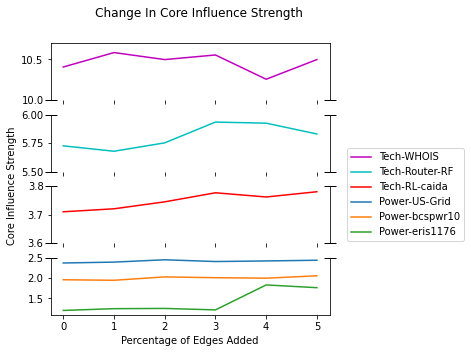

In [ ]:
edges = [0,1,2,3,4,5]
caida_y = [3.7101,3.7205, 3.7448, 3.7765, 3.7618, 3.7801]
tech_routers_y = [5.7264, 5.6792, 5.7524, 5.9340, 5.9245, 5.8301]
tech_WHOIS_y = [10.4064, 10.5829, 10.4973, 10.5535, 10.2567, 10.4973]
Power_US_Grid_y = [2.3676, 2.3892, 2.4462, 2.4031, 2.4175, 2.435]
Power_bcspwr10_y = [1.9575, 1.9447,2.0270, 2.0078,1.9960, 2.0539]
Power_eris1176_y = [1.2069, 1.25, 1.2558, 1.2203, 1.8305, 1.7636]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4 , 1, sharex=True)
fig.set_size_inches(5,5)
fig.subplots_adjust(hspace=0.25)

d1,=ax4.plot(edges, Power_US_Grid_y, label="Power-US-Grid")
d2,=ax4.plot(edges, Power_bcspwr10_y, label="Power-bcspwr10")
d3,=ax4.plot(edges, Power_eris1176_y, label="Power-eris1176")
ax4.spines['top'].set_visible(False)
ax4.set_ylim(1.1, 2.5)

d4,=ax3.plot(edges, caida_y, color='r',label="Tech-RL-caida")
ax3.set_ylim(3.6, 3.8)
ax3.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)

d5,=ax2.plot(edges, tech_routers_y, color='c', label="Tech-Router-RF")
ax2.set_ylim(5.5 , 6)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

d6,=ax1.plot(edges, tech_WHOIS_y, color='m', label="Tech-WHOIS")
ax1.set_ylim(10, 10.7)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks(edges, minor=False)


d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)
ax3.plot([0, 1], [0, 0], transform=ax3.transAxes, **kwargs)
ax4.plot([0, 1], [1, 1], transform=ax4.transAxes, **kwargs)

plt.suptitle("       Change In Core Influence Strength")
plt.xlabel("Percentage of Edges Added")
ax2.set_ylabel("Core Influence Strength                           ")
plt.legend([d6, d5, d4, d1, d2, d3],["Tech-WHOIS", "Tech-Router-RF","Tech-RL-caida", "Power-US-Grid", "Power-bcspwr10", "Power-eris1176"], bbox_to_anchor = (1.5, 3))
plt.show()

Edge Resilience Visualisation 

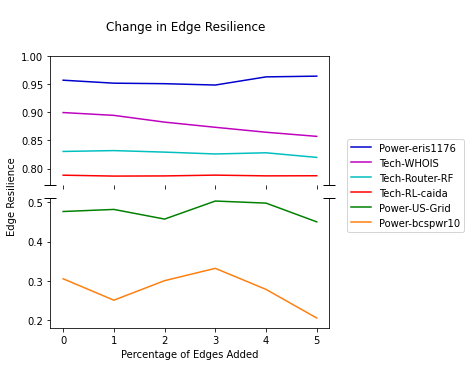

In [6]:
edges = [0,1,2,3,4,5]
caida_y = [0.7882, 0.7866, 0.7869, 0.7883, 0.7870, 0.7872]
tech_routers_y = [0.8304, 0.8319, 0.8292, 0.8259 , 0.8280, 0.8198]
tech_WHOIS_y = [0.8995, 0.8945,0.8825, 0.8733, 0.8645, 0.8572] 
Power_US_Grid_y = [0.4765,0.4818,0.4572,0.5032, 0.4979, 0.4501] 
Power_bcspwr10_y = [0.3050, 0.2504, 0.3002, 0.3316, 0.2779, 0.2049]
Power_eris1176_y = [0.9570, 0.9517, 0.9508 , 0.9484, 0.9629,  0.9642]

fig, (ax1, ax2) = plt.subplots(2 , 1, sharex=True)
fig.set_size_inches(5,5)
fig.subplots_adjust(hspace=0.1)

d4,=ax1.plot(edges, caida_y, color='r',label="Tech-RL-caida")
d5,=ax1.plot(edges, tech_routers_y, color='c', label="Tech-Router-RF")
d6,=ax1.plot(edges, tech_WHOIS_y, color='m', label="Tech-WHOIS")
d3,=ax1.plot(edges, Power_eris1176_y, color='mediumblue' ,label="Power-eris1176")
ax1.spines['bottom'].set_visible(False)
ax1.set_ylim(0.77, 1)

d1,=ax2.plot(edges, Power_US_Grid_y, color='g', label="Power-US-Grid")
d2,=ax2.plot(edges, Power_bcspwr10_y, color='tab:orange', label="Power-bcspwr10")
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0.18, 0.51)

d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


plt.suptitle("Change in Edge Resilience")
plt.xlabel("Percentage of Edges Added")
ax1.set_ylabel("Edge Resilience                                                ")
plt.legend([d3, d6, d5, d4, d1, d2],["Power-eris1176","Tech-WHOIS","Tech-Router-RF","Tech-RL-caida", "Power-US-Grid", "Power-bcspwr10"], bbox_to_anchor = (1.5, 1.5))
plt.show()

Node Resilience Visualisation

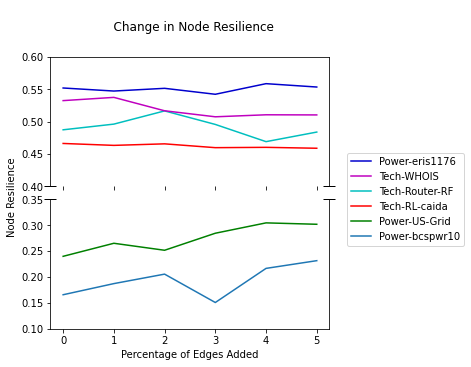

In [5]:
edges = [0,1,2,3,4,5]
caida_y = [0.4664, 0.46344, 0.4658, 0.4599, 0.4604, 0.4590]
tech_routers_y = [0.4875, 0.4963, 0.5167, 0.4958, 0.4692, 0.4840]
tech_WHOIS_y = [0.5326, 0.5376, 0.5169, 0.5076, 0.5107, 0.5105] 
Power_US_Grid_y = [0.2400, 0.2652,0.2517, 0.2846, 0.3046, 0.3019] 
Power_bcspwr10_y = [0.1658, 0.1873,0.2056, 0.1508, 0.2167, 0.2316]
Power_eris1176_y = [0.5521, 0.5474, 0.5516, 0.5424, 0.5588, 0.5536]

fig, (ax1, ax2) = plt.subplots(2 , 1, sharex=True)
fig.set_size_inches(5,5)
fig.subplots_adjust(hspace=0.1)

d4,=ax1.plot(edges, caida_y, color='r',label="Tech-RL-caida")
d5,=ax1.plot(edges, tech_routers_y, color='c', label="Tech-Router-RF")
d6,=ax1.plot(edges, tech_WHOIS_y, color='m', label="Tech-WHOIS")
d3,=ax1.plot(edges, Power_eris1176_y, color='mediumblue',label="Power-eris1176")
ax1.spines['bottom'].set_visible(False)
ax1.set_ylim(0.4, 0.6)

d1,=ax2.plot(edges, Power_US_Grid_y, color='g',label="Power-US-Grid")
d2,=ax2.plot(edges, Power_bcspwr10_y, label="Power-bcspwr10")
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0.1, 0.35)

d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


plt.suptitle("    Change in Node Resilience")
plt.xlabel("Percentage of Edges Added")
ax1.set_ylabel("Node Resilience                                                ")
plt.legend([d3, d6, d5, d4, d1, d2],["Power-eris1176","Tech-WHOIS","Tech-Router-RF","Tech-RL-caida", "Power-US-Grid", "Power-bcspwr10"], bbox_to_anchor = (1.5, 1.4))
plt.show()

# MRKC Algorithm Implementation

In [15]:
def CoreCheck(G, core_number_graph):
  coreCheck = {}
  nodes = G.nodes()
  for node in nodes: 
    coreCheck[node] = 0 
    neighbors = G.neighbors(node)

    for neighbor in neighbors: 
      if core_number_graph[node] <= core_number_graph[neighbor]:
        coreCheck[node] += 1
  return coreCheck

In [16]:
def updateCoreCheck(G, core_number_graph, coreCheck, edges):
  
  node = edges[0]
  neighbor = edges[1]

  if core_number_graph[node] > core_number_graph[neighbor]: 
    coreCheck[neighbor] += 1
  elif core_number_graph[node] < core_number_graph[neighbor]: 
    coreCheck[node] += 1
  elif core_number_graph[node] == core_number_graph[neighbor]: 
    coreCheck[neighbor] += 1
    coreCheck[node] += 1

  return coreCheck

In [17]:
def PureCore(G, core_number_graph, coreCheck, instance): 

  nodes = [node for node in core_number_graph if core_number_graph[node] == core_number_graph[instance]]

  nodes = [node for node in nodes if coreCheck[node] > core_number_graph[instance]]

  nodes.append(instance)
  nodes = set(nodes)

  subgraph = G.subgraph(nodes)
  connected = nx.connected_components(subgraph)

  for components in connected: 
    if instance in components: 
      components.remove(instance)
      return components 
  return set([])

In [30]:
def UpdatePureCore(G, core_graph_number, coreCheck, pure_core, edge): 

  edge_list = list(edge)
  node = edge_list[0]
  neighbor = edge_list[1]

  if core_graph_number[node] != core_graph_number[neighbor]:
    return pure_core 
  
  if coreCheck[node] > core_graph_number[neighbor]: 
    test = PureCore(G, core_graph_number, coreCheck, neighbor)
    if pure_core[neighbor] != test: 
        pure_core[neighbor] = test
  if core_graph_number[node] < coreCheck[neighbor]: 
    test = PureCore(G, core_graph_number, coreCheck, node)
    if pure_core[node] != test:
      pure_core[node] = test 

  for instance in pure_core[node]:
    if coreCheck[neighbor] > core_graph_number[instance]:
      test = PureCore(G, core_graph_number, coreCheck, instance)
      if pure_core[instance] != test: 
        pure_core[instance] = test

  for instance in pure_core[neighbor]:
    if coreCheck[node] > core_graph_number[instance]:
      test = PureCore(G, core_graph_number, coreCheck, instance)
      if pure_core[instance] != test: 
        pure_core[instance] = test
  
  return pure_core 

In [19]:
def GenPureCore(G, core_graph_number, coreCheck):
  pure_core = {}

  nodes = G.nodes()

  for node in nodes: 
    pure_core[node] = PureCore(G, core_graph_number, coreCheck, node)
  
  return pure_core

In [20]:
def CandidateEdges(G, core_number_graph, pure_core, nodes): 

  candidateEdges = []
  while len(nodes) >= 2: 
      first_node = nodes.pop()

      if first_node not in G.nodes(): 
        continue 
      
      CandidateNodes = nodes.difference(G.neighbors(first_node))

      for second_node in CandidateNodes: 
          candidateEdges.append((first_node, second_node))

  fit_edges = RemoveUnfit(G, candidateEdges, core_number_graph, pure_core)

  return fit_edges

In [21]:
def RemoveUnfit(G , edges, core_graph_number, pure_core): 

  matrix = nx.to_numpy_matrix(G)

  speedup_group = Groups(edges, core_graph_number, G, pure_core) 

  speedup_group_size = len(speedup_group)

  fit_edges = set([])

  for edges in range(0, speedup_group_size): 

    edge = speedup_group[edges]

    approved = CoreChangeMat(matrix, edge, core_graph_number)

    fit_edges.update(approved)

  return fit_edges



In [22]:
def Priority(edges, core_graph_number, coreStrength, coreInfluence): 

  priority = {}

  number_edges = len(edges)

  for edge in edges: 
    edge_list = list(edge)

    first = edge_list[0]
    second = edge_list[1]

    priority[(first, second)] = _ciPriority(core_graph_number, coreInfluence, coreStrength, first, second)

  if number_edges > 1000000: 
    threshold = np.percentile(list(priority.values()), 75)
    priority = {edge:priority[edge] for edge in priority if priority[edge] >= threshold}
  elif number_edges > 2000: 
    threshold = np.median(list(priority.values()))
    priority = {edge:priority[edge] for edge in priority if priority[edge] >= threshold}

  assigned_edges = sorted(priority, key=priority.get, reverse=True)

  return assigned_edges


In [23]:
def _ciPriority(core_graph_number, CoreInfluence, CoreStrength, first, second): 
  
  priority = 0 

  if core_graph_number[first] >= core_graph_number[second]:

    priority += CoreInfluence[second] / CoreStrength[second]

  if core_graph_number[first] <= core_graph_number[second]: 

    priority += CoreInfluence[first] / CoreStrength[first]

  return priority


In [24]:
def Groups(edges, core_graph_number, G, pure_core): 

  similar = set([edge for edge in edges if core_graph_number[edge[0]] == core_graph_number[edge[1]]])
  dissimilar = set([edge for edge in edges if edge not in similar])

  node_edges = {}

  for edge in similar: 
    if edge[0] not in node_edges: 
      node_edges[edge[0]] = []
    if edge[1] not in node_edges: 
      node_edges[edge[1]] = []

    node_edges[edge[0]].append(edge)
    node_edges[edge[1]].append(edge)

  sim_edgelist = []
  dis_edgelist = []

  while len(similar) > 0:
    nodes = set([])
    sl = []
    spc = set([])
    scn = set([])

    for edge in similar: 
      if (core_graph_number[edge[0]] not in scn and core_graph_number[edge[1]] not in scn)\
        or (edge[0] not in spc and edge[1] not in spc): 
        sl.append(edge)
        nodes.update([edge[0], edge[1]])
        scn.update([core_graph_number[edge[0]], core_graph_number[edge[1]]])
        spc.update(pure_core[edge[0]])
        spc.update(pure_core[edge[1]])
    sim_edgelist.append(sl)
    similar.difference_update(sl)

  while len(dissimilar) > 0:
    nodes = set([])
    sl = []
    spc = set([])
    scn = {}
    for edge in dissimilar:
      if (core_graph_number[edge[0]] not in scn and core_graph_number[edge[1]] not in scn)\
      or (edge[0] not in spc and edge[1] not in spc):
        sl.append(edge)
        nodes.update([edge[0], edge[1]])
        scn[edge[0]] = [core_graph_number[edge[1]]]
        scn[edge[1]] = [core_graph_number[edge[0]]]
        spc.update(pure_core[edge[0]])
        spc.update(pure_core[edge[1]])
      elif edge[0] in nodes and len(scn[edge[0]]) < 2:
        if core_graph_number[edge[0]] < core_graph_number[edge[1]] and core_graph_number[edge[0]] > max(scn[edge[0]]):
          sl.append(edge)
          nodes.update([edge[0], edge[1]])
          scn[edge[0]].append(core_graph_number[edge[1]])
          scn[edge[1]] = [core_graph_number[edge[0]]]
          spc.update(pure_core[edge[0]])
          spc.update(pure_core[edge[1]])
        elif core_graph_number[edge[0]] > core_graph_number[edge[1]] and core_graph_number[edge[0]] < min(scn[edge[0]]):
          sl.append(edge)
          nodes.update([edge[0], edge[1]])
          scn[edge[0]].append(core_graph_number[edge[1]])
          scn[edge[1]] = [core_graph_number[edge[0]]]
          spc.update(pure_core[edge[0]])
          spc.update(pure_core[edge[1]])
      elif edge[1] in nodes and len(scn[edge[1]]) < 2:
          if core_graph_number[edge[1]] < core_graph_number[edge[0]] and core_graph_number[edge[1]] > max(scn[edge[1]]):
            sl.append(edge)
            nodes.update([edge[0], edge[1]])
            scn[edge[1]].append(core_graph_number[edge[0]])
            scn[edge[0]] = [core_graph_number[edge[1]]]
            spc.update(pure_core[edge[0]])
            spc.update(pure_core[edge[1]])
          elif core_graph_number[edge[1]] > core_graph_number[edge[0]] and core_graph_number[edge[1]] < min(scn[edge[1]]):
            sl.append(edge)
            nodes.update([edge[0], edge[1]])
            scn[edge[1]].append(core_graph_number[edge[0]])
            scn[edge[0]] = [core_graph_number[edge[1]]]
            spc.update(pure_core[edge[0]])
            spc.update(pure_core[edge[1]])
    dis_edgelist.append(sl)
		#dis = [e for e in dis if e not in sl]
    dissimilar.difference_update(sl)

  el = sim_edgelist + dis_edgelist

  return el


In [25]:
def CoreChangeMat(mat, edges, core_graph_number): 

  nodes = [] 

  for edge in edges: 
    nodes.append(edge[0])
    nodes.append(edge[1])

  num_nodes = len(nodes)
  core_nums = {nodes[node]:core_graph_number[nodes[node]] for node in range(0, num_nodes)}

  nodes = set(nodes)

  mini = min(core_nums.values())
  maxi = max(core_nums.values())

  for e in edges:
    mat[e[0],e[1]] = 1
    mat[e[1],e[0]] = 1

  rem = [core for core in core_graph_number if core_graph_number[core] < mini]
  mat = np.delete(mat, rem, 0)
  mat = np.delete(mat, rem, 1)

  s = np.matrix([1]*len(mat))
  s = np.transpose(s)

  min_var = mini 

  matrix_sparse = sparse.csr_matrix(mat)
  changed = set([])

  while min_var < maxi: 
    r = matrix_sparse.dot(s)
    can = np.where(s <= 0)[0]
    r[can, 0] = min_var + 1
    can = np.where(r <= min_var)[0]

    if len(can) == 0:
      min_var += 1 
      continue 

    s[can, 0] = 0
    can = nodes.intersection(can)

    for x in can: 
      if min_var != core_nums[x]: 
        changed.update([x])

  whitelist = []

  for edge in edges: 
    if edge[0] not in changed and edge[1] not in changed: 
      whitelist.append(edge)
    elif edge[0] in changed and edge[1] not in changed and core_graph_number[edge[0]] > core_graph_number[edge[1]]: 
      whitelist.append(edge)
    elif edge[1] in changed and edge[0] not in changed and core_graph_number[edge[1]] > core_graph_number[edge[0]]:
      whitelist.append(edge)

  return whitelist


In [26]:
def MRKC(G, k, percent): 

  G_matrix = nx.to_numpy_matrix(G)
  G = nx.from_numpy_matrix(G_matrix)
  core_graph_number = nx.core_number(G)
  
  core_values = core_graph_number.values()

  cutoff = sorted(core_values, reverse=True)[int(len(core_graph_number)*k/100)]

  step = int(G.number_of_edges()/100)  
  ustep = step

  nodes = set([u for u in core_graph_number if core_graph_number[u] > cutoff])
  
  coreCheck = CoreCheck(G, core_graph_number)
  pure_core = GenPureCore(G, core_graph_number, coreCheck)
	
  cs = CoreStrength(G, core_graph_number)
  ci = CoreInfluence(G, core_graph_number)

  nedges = CandidateEdges(G, core_graph_number, pure_core, nodes)
  
  nedges = Priority(nedges, core_graph_number, cs, ci)

  cnodes = []
  cedges = []
  i = 0
  while len(nedges) > 0 and i <= percent*step:
    edge = nedges.pop(0)

    if edge[0] in cnodes or edge[1] in cnodes: 
      cedges.append(edge)
      continue 
    else: 
      cnodes += [edge[0], edge[1]]

    G.add_edge(edge[0],edge[1])
    G_matrix[edge[0], edge[1]] = 1
    G_matrix[edge[1], edge[0]] = 1

    i += 1

    if i%ustep == 0 or len(nedges) < len(cedges): 
      nedges = nedges + cedges 
      cedges = []
      cnodes = []

      coreCheck = CoreCheck(G, core_graph_number)
      pure_core = GenPureCore(G, core_graph_number, coreCheck)
     
      nedges = RemoveUnfit(G, nedges, core_graph_number,pure_core)
      cs = CoreStrength(G, core_graph_number)
      ci = CoreInfluence(G, core_graph_number)
      nedges = Priority(nedges, core_graph_number, cs, ci)

  return G


## MRKC RESULTS 

Tech-RL-caida

This testing cell crashes as I run out of RAM the method works fine for other data sets however this one is too large. 

In [ ]:
#Adding 1% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_one = MRKC(caida, 25 ,1)

nx.write_edgelist(caida_one, "caida_one.mtx", data=False)
caida_raw_one = "caida_one.mtx"

core_caida_one = core_number(caida_one)
influence_caida_one = CoreInfluence(caida_one, core_caida_one)
strength_caida_one = CoreStrength(caida_one, core_caida_one)

caida_CIS_one = CoreInfluenceStrength(influence_caida_one, strength_caida_one, 95)
caida_node_one = node_resilience(caida_raw_one, 5, 5, 0)
caida_edge_one = edge_resilience(caida_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_two = MRKC(caida,25, 2)

nx.write_edgelist(caida_two, "caida_two.mtx", data=False)
caida_raw_two = "caida_two.mtx"

core_caida_two = core_number(caida_two)
influence_caida_two = CoreInfluence(caida_two, core_caida_two)
strength_caida_two = CoreStrength(caida_two, core_caida_two)

caida_CIS_two = CoreInfluenceStrength(influence_caida_two, strength_caida_two, 95)
caida_node_two = node_resilience(caida_raw_two, 5, 5, 0)
caida_edge_two = edge_resilience(caida_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_three = MRKC(caida, 25,3)

nx.write_edgelist(caida_three, "caida_three.mtx", data=False)
caida_raw_three = "caida_three.mtx"

core_caida_three = core_number(caida_three)
influence_caida_three = CoreInfluence(caida_three, core_caida_three)
strength_caida_three = CoreStrength(caida_three, core_caida_three)

caida_CIS_three = CoreInfluenceStrength(influence_caida_three, strength_caida_three, 95)
caida_node_three = node_resilience(caida_raw_three, 5, 5, 0)
caida_edge_three = edge_resilience(caida_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_four = MRKC(caida, 25,4)

nx.write_edgelist(caida_four, "caida_four.mtx", data=False)
caida_raw_four = "caida_four.mtx"

core_caida_four = core_number(caida_four)
influence_caida_four = CoreInfluence(caida_four, core_caida_four)
strength_caida_four = CoreStrength(caida_four, core_caida_four)

caida_CIS_four = CoreInfluenceStrength(influence_caida_four, strength_caida_four, 95)
caida_node_four = node_resilience(caida_raw_four, 5, 5, 0)
caida_edge_four = edge_resilience(caida_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
caida = Import_graph_data('tech-RL-caida.mtx')
caida_five = MRKC(caida, 25,5)

nx.write_edgelist(caida_five, "caida_five.mtx", data=False)
caida_raw_five = "caida_five.mtx"

core_caida_five = core_number(caida_five)
influence_caida_five = CoreInfluence(caida_five, core_caida_five)
strength_caida_five = CoreStrength(caida_five, core_caida_five)

caida_CIS_five = CoreInfluenceStrength(influence_caida_five, strength_caida_five, 95)
caida_node_five = node_resilience(caida_raw_five, 5, 5, 0)
caida_edge_five = edge_resilience(caida_raw_five, 5, 5, 0)

In [ ]:
print(statistics(caida_one))
print(statistics(caida_two))
print(statistics(caida_three))
print(statistics(caida_four))
print(statistics(caida_five))

In [ ]:
print("Core Influence Strength: 1%: ", caida_CIS_one, " 2%: ", caida_CIS_two, " 3%: ", caida_CIS_three, " 4%: ", caida_CIS_four , " 5%: ", caida_CIS_five )
print("Node Resilience: 1%: ", caida_node_one, " 2%: ", caida_node_two, " 3%: ", caida_node_three, " 4%: ", caida_node_four , " 5%: ",  caida_node_five)
print("Edge Resilience: 1%: ", caida_edge_one, " 2%: ", caida_edge_two, " 3%: ", caida_edge_three, " 4%: ", caida_edge_four , " 5%: ",  caida_edge_five)

Tech-routers-rf

In [ ]:
# Adding 1% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_one = MRKC(tech_routers, 25 ,1)

nx.write_edgelist(tech_one, "tech_one.mtx", data=False)
tech_routers_raw_one = "tech_one.mtx"

core_tech_one = nx.core_number(tech_one)
influence_tech_one = CoreInfluence(tech_one, core_tech_one)
strength_tech_one = CoreStrength(tech_one, core_tech_one)

tech_CIS_one = CoreInfluenceStrength(influence_tech_one, strength_tech_one, 95)
tech_routers_node_one = node_resilience(tech_routers_raw_one, 5, 5, 0)
tech_routers_edge_one = edge_resilience(tech_routers_raw_one, 5, 5, 0)

# Adding 2% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_two = MRKC(tech_routers, 25 ,2)

nx.write_edgelist(tech_two, "tech_two.mtx", data=False)
tech_routers_raw_two = "tech_two.mtx"

core_tech_two = nx.core_number(tech_two)
influence_tech_two = CoreInfluence(tech_two, core_tech_two)
strength_tech_two = CoreStrength(tech_two, core_tech_two)

tech_CIS_two = CoreInfluenceStrength(influence_tech_two, strength_tech_two, 95)
tech_routers_node_two = node_resilience(tech_routers_raw_two, 5, 5, 0)
tech_routers_edge_two = edge_resilience(tech_routers_raw_two, 5, 5, 0)

# Adding 3% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_three = MRKC(tech_routers, 25 ,3)

nx.write_edgelist(tech_three, "tech_three.mtx", data=False)
tech_routers_raw_three = "tech_three.mtx"

core_tech_three = nx.core_number(tech_three)
influence_tech_three = CoreInfluence(tech_three, core_tech_three)
strength_tech_three = CoreStrength(tech_three, core_tech_three)

tech_CIS_three = CoreInfluenceStrength(influence_tech_three, strength_tech_three, 95)
tech_routers_node_three = node_resilience(tech_routers_raw_three, 5, 5, 0)
tech_routers_edge_three = edge_resilience(tech_routers_raw_three, 5, 5, 0)

#adding 4% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_four = MRKC(tech_routers, 25 ,4)

nx.write_edgelist(tech_four, "tech_four.mtx", data=False)
tech_routers_raw_four = "tech_four.mtx"

core_tech_four = nx.core_number(tech_four)
influence_tech_four = CoreInfluence(tech_four, core_tech_four)
strength_tech_four = CoreStrength(tech_four, core_tech_four)

tech_CIS_four = CoreInfluenceStrength(influence_tech_four, strength_tech_four, 95)
tech_routers_node_four = node_resilience(tech_routers_raw_four, 5, 5, 0)
tech_routers_edge_four = edge_resilience(tech_routers_raw_four, 5, 5, 0)

#adding 5% of total number of edges
tech_routers = Import_graph_data("tech-routers-rf.mtx")
tech_five = MRKC(tech_routers, 25 ,5)

nx.write_edgelist(tech_five, "tech_five.mtx", data=False)
tech_routers_raw_five = "tech_five.mtx"

core_tech_five = nx.core_number(tech_five)
influence_tech_five = CoreInfluence(tech_five, core_tech_five)
strength_tech_five = CoreStrength(tech_five, core_tech_five)

tech_CIS_five = CoreInfluenceStrength(influence_tech_five, strength_tech_five, 95)
tech_routers_node_five = node_resilience(tech_routers_raw_five, 5, 5, 0)
tech_routers_edge_five = edge_resilience(tech_routers_raw_five, 5, 5, 0)

In [ ]:
print(statistics(tech_one))
print(statistics(tech_two))
print(statistics(tech_three))
print(statistics(tech_four))
print(statistics(tech_five))

{'Number of Nodes': 2113, 'Number of Edges': 6699, 'Average Degree': 6.340747752011358, 'Density': 0.003002247988641742, 'Clustering Coefficient': 0.24587341741861923, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6765, 'Average Degree': 6.403218173213441, 'Density': 0.003031826786559394, 'Clustering Coefficient': 0.2443906322902569, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6831, 'Average Degree': 6.465688594415523, 'Density': 0.0030614055844770467, 'Clustering Coefficient': 0.2431986154406414, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6897, 'Average Degree': 6.5281590156176055, 'Density': 0.0030909843823946994, 'Clustering Coefficient': 0.24169083808637093, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6963, 'Average Degree': 6.590629436819688, 'Density': 0.003120563180312352, 'Clustering Coefficient': 0.2406969976772302, 'Maximum K-core': 15}


In [ ]:
print("Core Influence Strength: 1%: ", tech_CIS_one, " 2%: ", tech_CIS_two, " 3%: ", tech_CIS_three, " 4%: ", tech_CIS_four , " 5%: ", tech_CIS_five )
print("Node Resilience: 1%: ", tech_routers_node_one, " 2%: ", tech_routers_node_two, " 3%: ", tech_routers_node_three, " 4%: ", tech_routers_node_four, " 5%: ",  tech_routers_node_five)
print("Edge Resilience: 1%: ", tech_routers_edge_one, " 2%: ", tech_routers_edge_two, " 3%: ", tech_routers_edge_three, " 4%: ", tech_routers_edge_four , " 5%: ",  tech_routers_edge_five)

Core Influence Strength: 1%:  5.839622641509434  2%:  6.283018867924528  3%:  6.188679245283019  4%:  6.0754716981132075  5%:  6.2924528301886795
Node Resilience: 1%:  {50: 0.4877035582845316}  2%:  {50: 0.5046149216239924}  3%:  {50: 0.47818323463232815}  4%:  {50: 0.5102810284008349}  5%:  {50: 0.5100151866146448}
Edge Resilience: 1%:  {50: 0.8326687209029165}  2%:  {50: 0.8409332354800506}  3%:  {50: 0.8449928762282877}  4%:  {50: 0.8500786341033295}  5%:  {50: 0.8538744255128575}


Tech-WHOIS

In [ ]:
#Adding 1% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_one = MRKC(tech_who, 25,1)

nx.write_edgelist(techW_one, "techW_one.mtx", data=False)
tech_who_raw_one = "techW_one.mtx"

core_techW_one = core_number(techW_one)
influence_techW_one = CoreInfluence(techW_one, core_techW_one)
strength_techW_one = CoreStrength(techW_one, core_techW_one)

techW_CIS_one = CoreInfluenceStrength(influence_techW_one, strength_techW_one, 95)
tech_who_node_one = node_resilience(tech_who_raw_one, 5, 5, 0)
tech_who_edge_one = edge_resilience(tech_who_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_two = MRKC(tech_who,25, 2)

nx.write_edgelist(techW_two, "techW_two.mtx", data=False)
tech_who_raw_two = "techW_two.mtx"

core_techW_two = core_number(techW_two)
influence_techW_two = CoreInfluence(techW_two, core_techW_two)
strength_techW_two = CoreStrength(techW_two, core_techW_two)

techW_CIS_two = CoreInfluenceStrength(influence_techW_two, strength_techW_two, 95)
tech_who_node_two = node_resilience(tech_who_raw_two, 5, 5, 0)
tech_who_edge_two = edge_resilience(tech_who_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_three = MRKC(tech_who,25, 3)

nx.write_edgelist(techW_three, "techW_three.mtx", data=False)
tech_who_raw_three = "techW_three.mtx"

core_techW_three = core_number(techW_three)
influence_techW_three = CoreInfluence(techW_three, core_techW_three)
strength_techW_three = CoreStrength(techW_three, core_techW_three)

techW_CIS_three = CoreInfluenceStrength(influence_techW_three, strength_techW_three, 95)
tech_who_node_three = node_resilience(tech_who_raw_three, 5, 5, 0)
tech_who_edge_three = edge_resilience(tech_who_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_four = MRKC(tech_who, 25,4)

nx.write_edgelist(techW_four, "techW_four.mtx", data=False)
tech_who_raw_four = "techW_four.mtx"

core_techW_four = core_number(techW_four)
influence_techW_four = CoreInfluence(techW_four, core_techW_four)
strength_techW_four = CoreStrength(techW_four, core_techW_four)

techW_CIS_four = CoreInfluenceStrength(influence_techW_four, strength_techW_four, 95)
tech_who_node_four = node_resilience(tech_who_raw_four, 5, 5, 0)
tech_who_edge_four = edge_resilience(tech_who_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
tech_who = Import_graph_data('tech-WHOIS.mtx')
techW_five = MRKC(tech_who, 25, 5)

nx.write_edgelist(techW_five, "techW_five.mtx", data=False)
tech_who_raw_five = "techW_five.mtx"

core_techW_five = core_number(techW_five)
influence_techW_five = CoreInfluence(techW_five, core_techW_five)
strength_techW_five = CoreStrength(techW_five, core_techW_five)

techW_CIS_five = CoreInfluenceStrength(influence_techW_five, strength_techW_five, 95)
tech_who_node_five = node_resilience(tech_who_raw_five, 5, 5, 0)
tech_who_edge_five = edge_resilience(tech_who_raw_five, 5, 5, 0)

In [ ]:
print(statistics(techW_one))
print(statistics(techW_two))
print(statistics(techW_three))
print(statistics(techW_four))
print(statistics(techW_five))

{'Number of Nodes': 7476, 'Number of Edges': 57513, 'Average Degree': 15.386035313001605, 'Density': 0.0020583324833446963, 'Clustering Coefficient': 0.4908801967879764, 'Maximum K-core': 90}
{'Number of Nodes': 7476, 'Number of Edges': 57559, 'Average Degree': 15.398341359015516, 'Density': 0.0020599787771258217, 'Clustering Coefficient': 0.49151181210279155, 'Maximum K-core': 90}
{'Number of Nodes': 7476, 'Number of Edges': 57559, 'Average Degree': 15.398341359015516, 'Density': 0.0020599787771258217, 'Clustering Coefficient': 0.49151181210279155, 'Maximum K-core': 90}
{'Number of Nodes': 7476, 'Number of Edges': 57559, 'Average Degree': 15.398341359015516, 'Density': 0.0020599787771258217, 'Clustering Coefficient': 0.49151181210279155, 'Maximum K-core': 90}
{'Number of Nodes': 7476, 'Number of Edges': 57559, 'Average Degree': 15.398341359015516, 'Density': 0.0020599787771258217, 'Clustering Coefficient': 0.49151181210279155, 'Maximum K-core': 90}


In [ ]:
print("Core Influence Strength: 1%: ", techW_CIS_one, " 2%: ", techW_CIS_two, " 3%: ", techW_CIS_three, " 4%: ", techW_CIS_four , " 5%: ", techW_CIS_five )
print("Node Resilience: 1%: ", tech_who_node_one, " 2%: ", tech_who_node_two, " 3%: ", tech_who_node_three, " 4%: ", tech_who_node_four, " 5%: ",  tech_who_node_five)
print("Edge Resilience: 1%: ", tech_who_edge_one, " 2%: ", tech_who_edge_two, " 3%: ", tech_who_edge_three, " 4%: ", tech_who_edge_four , " 5%: ",  tech_who_edge_five)

Core Influence Strength: 1%:  11.0  2%:  11.216577540106952  3%:  11.216577540106952  4%:  11.216577540106952  5%:  11.216577540106952
Node Resilience: 1%:  {50: 0.5298467085273262}  2%:  {50: 0.5275516975081116}  3%:  {50: 0.5383569638420445}  4%:  {50: 0.5311586118148177}  5%:  {50: 0.5321667469270361}
Edge Resilience: 1%:  {50: 0.9030731021138079}  2%:  {50: 0.9035173587825611}  3%:  {50: 0.9038763786421379}  4%:  {50: 0.9038886627376362}  5%:  {50: 0.9036801667188386}


Power-US-Grid

In [ ]:
#Adding 1% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_one = MRKC(power_US, 25,1)

nx.write_edgelist(power_US_one, "power_US_one.mtx", data=False)
power_US_raw_one = "power_US_one.mtx"

core_powerUS_one = core_number(power_US_one)
influence_powerUS_one = CoreInfluence(power_US_one, core_powerUS_one)
strength_powerUS_one = CoreStrength(power_US_one, core_powerUS_one)

powerUS_CIS_one = CoreInfluenceStrength(influence_powerUS_one, strength_powerUS_one, 95)
power_US_node_one = node_resilience(power_US_raw_one, 5, 5, 0)
power_US_edge_one = edge_resilience(power_US_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_two = MRKC(power_US,25, 2)

nx.write_edgelist(power_US_two, "power_US_two.mtx", data=False)
power_US_raw_two = "power_US_two.mtx"

core_powerUS_two = core_number(power_US_two)
influence_powerUS_two = CoreInfluence(power_US_two, core_powerUS_two)
strength_powerUS_two = CoreStrength(power_US_two, core_powerUS_two)

powerUS_CIS_two = CoreInfluenceStrength(influence_powerUS_two, strength_powerUS_two, 95)
power_US_node_two = node_resilience(power_US_raw_two, 5, 5, 0)
power_US_edge_two = edge_resilience(power_US_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_three = MRKC(power_US,25, 3)

nx.write_edgelist(power_US_three, "power_US_three.mtx", data=False)
power_US_raw_three = "power_US_three.mtx"

core_powerUS_three = core_number(power_US_three)
influence_powerUS_three = CoreInfluence(power_US_three, core_powerUS_three)
strength_powerUS_three = CoreStrength(power_US_three, core_powerUS_three)

powerUS_CIS_three = CoreInfluenceStrength(influence_powerUS_three, strength_powerUS_three, 95)
power_US_node_three = node_resilience(power_US_raw_three, 5, 5, 0)
power_US_edge_three = edge_resilience(power_US_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_four = MRKC(power_US,25, 4)

nx.write_edgelist(power_US_four, "power_US_four.mtx", data=False)
power_US_raw_four = "power_US_four.mtx"

core_powerUS_four = core_number(power_US_four)
influence_powerUS_four = CoreInfluence(power_US_four, core_powerUS_four)
strength_powerUS_four = CoreStrength(power_US_four, core_powerUS_four)

powerUS_CIS_four = CoreInfluenceStrength(influence_powerUS_four, strength_powerUS_four, 95)
power_US_node_four = node_resilience(power_US_raw_four, 5, 5, 0)
power_US_edge_four = edge_resilience(power_US_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
power_US = Import_graph_data('power-US-Grid.mtx')
power_US_five = MRKC(power_US,25, 5)

nx.write_edgelist(power_US_five, "power_US_five.mtx", data=False)
power_US_raw_five = "power_US_five.mtx"

core_powerUS_five = core_number(power_US_five)
influence_powerUS_five = CoreInfluence(power_US_five, core_powerUS_five)
strength_powerUS_five = CoreStrength(power_US_five, core_powerUS_five)

powerUS_CIS_five = CoreInfluenceStrength(influence_powerUS_five, strength_powerUS_five, 95)
power_US_node_five = node_resilience(power_US_raw_five, 5, 5, 0)
power_US_edge_five = edge_resilience(power_US_raw_five, 5, 5, 0)

In [ ]:
print(statistics(power_US_one))
print(statistics(power_US_two))
print(statistics(power_US_three))
print(statistics(power_US_four))
print(statistics(power_US_five))

{'Number of Nodes': 4948, 'Number of Edges': 6667, 'Average Degree': 2.69482619240097, 'Density': 0.0005447394769357125, 'Clustering Coefficient': 0.07872477894882256, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6733, 'Average Degree': 2.721503637833468, 'Density': 0.0005501321281248167, 'Clustering Coefficient': 0.0774396990440562, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6799, 'Average Degree': 2.748181083265966, 'Density': 0.0005555247793139207, 'Clustering Coefficient': 0.0754708285672349, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6865, 'Average Degree': 2.774858528698464, 'Density': 0.0005609174305030249, 'Clustering Coefficient': 0.07453636137146956, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6931, 'Average Degree': 2.801535974130962, 'Density': 0.000566310081692129, 'Clustering Coefficient': 0.07409612986024465, 'Maximum K-core': 6}


In [ ]:
print("Core Influence Strength: 1%: ", powerUS_CIS_one, " 2%: ", powerUS_CIS_two, " 3%: ", powerUS_CIS_three, " 4%: ", powerUS_CIS_four , " 5%: ", powerUS_CIS_five )
print("Node Resilience: 1%: ", power_US_node_one, " 2%: ", power_US_node_two, " 3%: ", power_US_node_three, " 4%: ", power_US_node_four, " 5%: ",  power_US_node_five)
print("Edge Resilience: 1%: ", power_US_edge_one, " 2%: ", power_US_edge_two, " 3%: ", power_US_edge_three, " 4%: ", power_US_edge_four , " 5%: ",  power_US_edge_five)

Core Influence Strength: 1%:  2.845  2%:  3.38265306122449  3%:  3.0344827586206895  4%:  2.797029702970297  5%:  2.909547738693467
Node Resilience: 1%:  {50: 0.3280446913946361}  2%:  {50: 0.2664577582526762}  3%:  {50: 0.2895124604856681}  4%:  {50: 0.2895943622847597}  5%:  {50: 0.36145293191789574}
Edge Resilience: 1%:  {50: 0.5665236470958499}  2%:  {50: 0.46334148934695446}  3%:  {50: 0.5726394811198785}  4%:  {50: 0.5947031863675776}  5%:  {50: 0.660094445599585}


Power-bcspwr10

In [37]:
#Adding 1% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_one = MRKC(power_BC,25, 1)

nx.write_edgelist(power_BC_one, "power_BC_one.mtx", data=False)
power_BC_raw_one = "power_BC_one.mtx"

core_powerBC_one = core_number(power_BC_one)
influence_powerBC_one = CoreInfluence(power_BC_one, core_powerBC_one)
strength_powerBC_one = CoreStrength(power_BC_one, core_powerBC_one)

powerBC_CIS_one = CoreInfluenceStrength(influence_powerBC_one, strength_powerBC_one, 95)
power_BC_node_one = node_resilience(power_BC_raw_one, 5, 5, 0)
power_BC_edge_one = edge_resilience(power_BC_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_two = MRKC(power_BC,25, 2)

nx.write_edgelist(power_BC_two, "power_BC_two.mtx", data=False)
power_BC_raw_two = "power_BC_two.mtx"

core_powerBC_two = core_number(power_BC_two)
influence_powerBC_two = CoreInfluence(power_BC_two, core_powerBC_two)
strength_powerBC_two = CoreStrength(power_BC_two, core_powerBC_two)

powerBC_CIS_two = CoreInfluenceStrength(influence_powerBC_two, strength_powerBC_two, 95)
power_BC_node_two = node_resilience(power_BC_raw_two, 5, 5, 0)
power_BC_edge_two = edge_resilience(power_BC_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_three = MRKC(power_BC,25, 3)

nx.write_edgelist(power_BC_three, "power_BC_three.mtx", data=False)
power_BC_raw_three = "power_BC_three.mtx"

core_powerBC_three = core_number(power_BC_three)
influence_powerBC_three = CoreInfluence(power_BC_three, core_powerBC_three)
strength_powerBC_three = CoreStrength(power_BC_three, core_powerBC_three)

powerBC_CIS_three = CoreInfluenceStrength(influence_powerBC_three, strength_powerBC_three, 95)
power_BC_node_three = node_resilience(power_BC_raw_three, 5, 5, 0)
power_BC_edge_three = edge_resilience(power_BC_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_four = MRKC(power_BC,25, 4)

nx.write_edgelist(power_BC_four, "power_BC_four.mtx", data=False)
power_BC_raw_four = "power_BC_four.mtx"

core_powerBC_four = core_number(power_BC_four)
influence_powerBC_four = CoreInfluence(power_BC_four, core_powerBC_four)
strength_powerBC_four = CoreStrength(power_BC_four, core_powerBC_four)

powerBC_CIS_four = CoreInfluenceStrength(influence_powerBC_four, strength_powerBC_four, 95)
power_BC_node_four = node_resilience(power_BC_raw_four, 5, 5, 0)
power_BC_edge_four = edge_resilience(power_BC_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
power_BC = Import_graph_data('power-bcspwr10.mtx')
power_BC_five = MRKC(power_BC,25, 5)

nx.write_edgelist(power_BC_five, "power_BC_five.mtx", data=False)
power_BC_raw_five = "power_BC_five.mtx"

core_powerBC_five = core_number(power_BC_five)
influence_powerBC_five = CoreInfluence(power_BC_five, core_powerBC_five)
strength_powerBC_five = CoreStrength(power_BC_five, core_powerBC_five)

powerBC_CIS_five = CoreInfluenceStrength(influence_powerBC_five, strength_powerBC_five, 95)
power_BC_node_five = node_resilience(power_BC_raw_five, 5, 5, 0)
power_BC_edge_five = edge_resilience(power_BC_raw_five, 5, 5, 0)

In [ ]:
print(statistics(power_BC_one))
print(statistics(power_BC_two))
print(statistics(power_BC_three))
print(statistics(power_BC_four))
print(statistics(power_BC_five))

{'Number of Nodes': 5305, 'Number of Edges': 8358, 'Average Degree': 3.150989632422243, 'Density': 0.0005940779849966522, 'Clustering Coefficient': 0.08453790737485324, 'Maximum K-core': 4}
{'Number of Nodes': 5305, 'Number of Edges': 8440, 'Average Degree': 3.1819038642789823, 'Density': 0.0005999064600827643, 'Clustering Coefficient': 0.08308860895100255, 'Maximum K-core': 5}
{'Number of Nodes': 5305, 'Number of Edges': 8522, 'Average Degree': 3.212818096135721, 'Density': 0.0006057349351688765, 'Clustering Coefficient': 0.08239741408450131, 'Maximum K-core': 6}
{'Number of Nodes': 5305, 'Number of Edges': 8604, 'Average Degree': 3.24373232799246, 'Density': 0.0006115634102549887, 'Clustering Coefficient': 0.08208270587685074, 'Maximum K-core': 6}
{'Number of Nodes': 5305, 'Number of Edges': 8686, 'Average Degree': 3.2746465598491987, 'Density': 0.0006173918853411008, 'Clustering Coefficient': 0.08185720860380795, 'Maximum K-core': 6}


In [ ]:
print("Core Influence Strength: 1%: ", powerBC_CIS_one, " 2%: ", powerBC_CIS_two, " 3%: ", powerBC_CIS_three, " 4%: ", powerBC_CIS_four , " 5%: ", powerBC_CIS_five )
print("Node Resilience: 1%: ", power_BC_node_one, " 2%: ", power_BC_node_two, " 3%: ", power_BC_node_three, " 4%: ", power_BC_node_four, " 5%: ",  power_BC_node_five)
print("Edge Resilience: 1%: ", power_BC_edge_one, " 2%: ", power_BC_edge_two, " 3%: ", power_BC_edge_three, " 4%: ", power_BC_edge_four , " 5%: ",  power_BC_edge_five)

Core Influence Strength: 1%:  2.1882352941176473  2%:  2.295275590551181  3%:  2.5952380952380953  4%:  2.9563492063492065  5%:  3.2976190476190474
Node Resilience: 1%:  {50: 0.17584171687672281}  2%:  {50: 0.27512286030600563}  3%:  {50: 0.2502821498237616}  4%:  {50: 0.2609448712727591}  5%:  {50: 0.22433212642511813}
Edge Resilience: 1%:  {50: 0.3352457462244619}  2%:  {50: 0.4464332776813573}  3%:  {50: 0.5484197613948922}  4%:  {50: 0.4223046071677959}  5%:  {50: 0.4576910282916666}


Power-eris1176

In [31]:
#Adding 1% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_one = MRKC(power_E,25, 1)

nx.write_edgelist(power_E_one, "power_E_one.mtx", data=False)
power_E_raw_one = "power_E_one.mtx"

core_powerE_one = core_number(power_E_one)
influence_powerE_one = CoreInfluence(power_E_one, core_powerE_one)
strength_powerE_one = CoreStrength(power_E_one, core_powerE_one)

powerE_CIS_one = CoreInfluenceStrength(influence_powerE_one, strength_powerE_one, 95)
power_E_node_one = node_resilience(power_E_raw_one, 5, 5, 0)
power_E_edge_one = edge_resilience(power_E_raw_one, 5, 5, 0)

#Adding 2% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_two = MRKC(power_E,25,2)

nx.write_edgelist(power_E_two, "power_E_two.mtx", data=False)
power_E_raw_two = "power_E_two.mtx"

core_powerE_two = core_number(power_E_two)
influence_powerE_two = CoreInfluence(power_E_two, core_powerE_two)
strength_powerE_two = CoreStrength(power_E_two, core_powerE_two)

powerE_CIS_two = CoreInfluenceStrength(influence_powerE_two, strength_powerE_two, 95)
power_E_node_two = node_resilience(power_E_raw_two, 5, 5, 0)
power_E_edge_two = edge_resilience(power_E_raw_two, 5, 5, 0)

#Adding 3% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_three = MRKC(power_E, 25, 3)

nx.write_edgelist(power_E_three, "power_E_three.mtx", data=False)
power_E_raw_three = "power_E_three.mtx"

core_powerE_three = core_number(power_E_three)
influence_powerE_three = CoreInfluence(power_E_three, core_powerE_three)
strength_powerE_three = CoreStrength(power_E_three, core_powerE_three)

powerE_CIS_three = CoreInfluenceStrength(influence_powerE_three, strength_powerE_three, 95)
power_E_node_three = node_resilience(power_E_raw_three, 5, 5, 0)
power_E_edge_three = edge_resilience(power_E_raw_three, 5, 5, 0)

#Adding 4% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_four = MRKC(power_E,25, 4)

nx.write_edgelist(power_E_four, "power_E_four.mtx", data=False)
power_E_raw_four = "power_E_four.mtx"

core_powerE_four = core_number(power_E_four)
influence_powerE_four = CoreInfluence(power_E_four, core_powerE_four)
strength_powerE_four = CoreStrength(power_E_four, core_powerE_four)

powerE_CIS_four = CoreInfluenceStrength(influence_powerE_four, strength_powerE_four, 95)
power_E_node_four = node_resilience(power_E_raw_four, 5, 5, 0)
power_E_edge_four = edge_resilience(power_E_raw_four, 5, 5, 0)

#Adding 5% more edges than total number of edges
power_E = Import_graph_data('power-eris1176.mtx')
power_E_five = MRKC(power_E,25, 5)

nx.write_edgelist(power_E_five, "power_E_five.mtx", data=False)
power_E_raw_five = "power_E_five.mtx"

core_powerE_five = core_number(power_E_five)
influence_powerE_five = CoreInfluence(power_E_five, core_powerE_five)
strength_powerE_five = CoreStrength(power_E_five, core_powerE_five)

powerE_CIS_five = CoreInfluenceStrength(influence_powerE_five, strength_powerE_five, 95)
power_E_node_five = node_resilience(power_E_raw_five, 5, 5, 0)
power_E_edge_five = edge_resilience(power_E_raw_five, 5, 5, 0)

In [32]:
print(statistics(power_E_one))
print(statistics(power_E_two))
print(statistics(power_E_three))
print(statistics(power_E_four))
print(statistics(power_E_five))

{'Number of Nodes': 1181, 'Number of Edges': 8779, 'Average Degree': 14.867061812023708, 'Density': 0.012599204925443822, 'Clustering Coefficient': 0.4239666533599008, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 8865, 'Average Degree': 15.012701100762065, 'Density': 0.012722628051493276, 'Clustering Coefficient': 0.41876492883783895, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 8951, 'Average Degree': 15.158340389500424, 'Density': 0.012846051177542731, 'Clustering Coefficient': 0.41423950071836324, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 9037, 'Average Degree': 15.30397967823878, 'Density': 0.012969474303592188, 'Clustering Coefficient': 0.40997799380029826, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 9098, 'Average Degree': 15.407281964436917, 'Density': 0.013057018613929591, 'Clustering Coefficient': 0.40736482432648846, 'Maximum K-core': 79}


In [33]:
print("Core Influence Strength: 1%: ", powerE_CIS_one, " 2%: ", powerE_CIS_two, " 3%: ", powerE_CIS_three, " 4%: ", powerE_CIS_four , " 5%: ", powerE_CIS_five)
print("Node Resilience: 1%: ", power_E_node_one, " 2%: ", power_E_node_two, " 3%: ", power_E_node_three, " 4%: ", power_E_node_four, " 5%: ",  power_E_node_five)
print("Edge Resilience: 1%: ", power_E_edge_one, " 2%: ", power_E_edge_two, " 3%: ", power_E_edge_three, " 4%: ", power_E_edge_four , " 5%: ",  power_E_edge_five)

Core Influence Strength: 1%:  1.56  2%:  1.7333333333333334  3%:  2.0344827586206895  4%:  2.1333333333333333  5%:  2.2333333333333334
Node Resilience: 1%:  {50: 0.5596156446120076}  2%:  {50: 0.5495763265509079}  3%:  {50: 0.5743341320696391}  4%:  {50: 0.5508976715312006}  5%:  {50: 0.5592394428808245}
Edge Resilience: 1%:  {50: 0.9557419356435404}  2%:  {50: 0.9552520313313133}  3%:  {50: 0.9564388739640497}  4%:  {50: 0.9571126044622469}  5%:  {50: 0.9572511178368115}


## MRKC results visualisation

Core Influence visualization

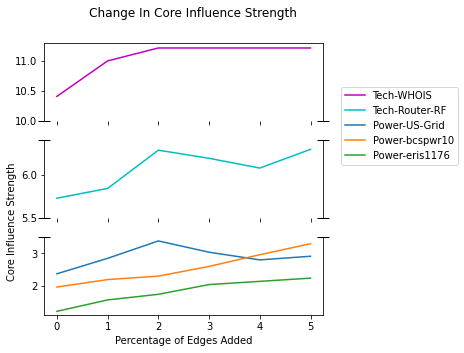

In [40]:
edges = [0,1,2,3,4,5]
tech_routers_y = [5.7264,  5.8396,  6.2830, 6.1887, 6.0755,  6.2925 ]
tech_WHOIS_y = [10.4064, 11.0, 11.2166, 11.2166, 11.2166, 11.2166]
Power_US_Grid_y = [2.3676, 2.845, 3.3827, 3.0345,  2.7970, 2.9095]
Power_bcspwr10_y = [1.9575, 2.1882, 2.2953, 2.5952 , 2.9563, 3.2976]
Power_eris1176_y = [1.2069, 1.56, 1.7333, 2.0344 , 2.1333, 2.2333]

fig, (ax1, ax2, ax4) = plt.subplots(3 , 1, sharex=True)
fig.set_size_inches(5,5)
fig.subplots_adjust(hspace=0.25)

d1,=ax4.plot(edges, Power_US_Grid_y, label="Power-US-Grid")
d2,=ax4.plot(edges, Power_bcspwr10_y, label="Power-bcspwr10")
d3,=ax4.plot(edges, Power_eris1176_y, label="Power-eris1176")
ax4.spines['top'].set_visible(False)
ax4.set_ylim(1.1, 3.5)


d5,=ax2.plot(edges, tech_routers_y, color='c', label="Tech-Router-RF")
ax2.set_ylim(5.5 , 6.4)
ax2.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

d6,=ax1.plot(edges, tech_WHOIS_y, color='m', label="Tech-WHOIS")
ax1.set_ylim(10, 11.35)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks(edges, minor=False)


d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax4.plot([0, 1], [1, 1], transform=ax4.transAxes, **kwargs)

plt.suptitle("       Change In Core Influence Strength")
plt.xlabel("Percentage of Edges Added")
ax2.set_ylabel("Core Influence Strength                           ")
plt.legend([d6, d5, d1, d2, d3],["Tech-WHOIS", "Tech-Router-RF", "Power-US-Grid", "Power-bcspwr10", "Power-eris1176"], bbox_to_anchor = (1.5, 3))
plt.show()

Edge resilience visualization

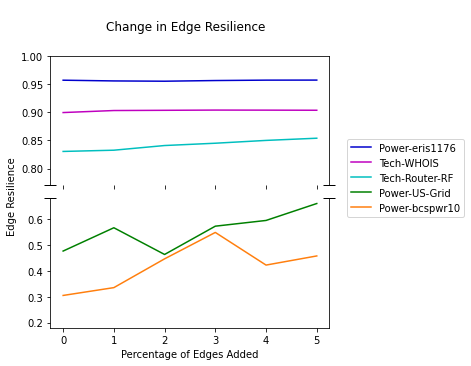

In [43]:
edges = [0,1,2,3,4,5]
tech_routers_y = [0.8304, 0.8326, 0.8409, 0.8450,  0.85, 0.8539 ]
tech_WHOIS_y = [0.8995, 0.9031, 0.9035, 0.9039, 0.9038, 0.9036] 
Power_US_Grid_y = [0.4765, 0.5665, 0.4633, 0.5726, 0.5947, 0.6601 ] 
Power_bcspwr10_y = [0.3050, 0.3352, 0.4464, 0.5484, 0.4223, 0.4576]
Power_eris1176_y = [0.9570, 0.9557, 0.9552, 0.9564, 0.9571, 0.9572 ]

fig, (ax1, ax2) = plt.subplots(2 , 1, sharex=True)
fig.set_size_inches(5,5)
fig.subplots_adjust(hspace=0.1)


d5,=ax1.plot(edges, tech_routers_y, color='c', label="Tech-Router-RF")
d6,=ax1.plot(edges, tech_WHOIS_y, color='m', label="Tech-WHOIS")
d3,=ax1.plot(edges, Power_eris1176_y, color='mediumblue' ,label="Power-eris1176")
ax1.spines['bottom'].set_visible(False)
ax1.set_ylim(0.77, 1)

d1,=ax2.plot(edges, Power_US_Grid_y, color='g', label="Power-US-Grid")
d2,=ax2.plot(edges, Power_bcspwr10_y, color='tab:orange', label="Power-bcspwr10")
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0.18, 0.68)

d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


plt.suptitle("Change in Edge Resilience")
plt.xlabel("Percentage of Edges Added")
ax1.set_ylabel("Edge Resilience                                                ")
plt.legend([d3, d6, d5, d1, d2],["Power-eris1176","Tech-WHOIS","Tech-Router-RF","Power-US-Grid", "Power-bcspwr10"], bbox_to_anchor = (1.5, 1.5))
plt.show()

Node resilience visualisation

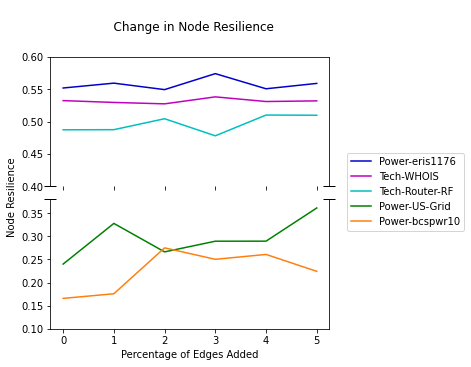

In [3]:
edges = [0,1,2,3,4,5]
tech_routers_y = [0.4875, 0.4877, 0.5046, 0.4782 , 0.5103, 0.51]
tech_WHOIS_y = [0.5326, 0.5298, 0.5276, 0.5384, 0.5312, 0.5322] 
Power_US_Grid_y = [0.2400, 0.3280, 0.2664, 0.2895, 0.2896, 0.36145] 
Power_bcspwr10_y = [0.1658, 0.1758, 0.2751, 0.2503, 0.2609, 0.2243]
Power_eris1176_y = [0.5521,0.5596,0.5496, 0.5743, 0.5509,0.5592 ]

fig, (ax1, ax2) = plt.subplots(2 , 1, sharex=True)
fig.set_size_inches(5,5)
fig.subplots_adjust(hspace=0.1)


d5,=ax1.plot(edges, tech_routers_y, color='c', label="Tech-Router-RF")
d6,=ax1.plot(edges, tech_WHOIS_y, color='m', label="Tech-WHOIS")
d3,=ax1.plot(edges, Power_eris1176_y, color='mediumblue',label="Power-eris1176")
ax1.spines['bottom'].set_visible(False)
ax1.set_ylim(0.4, 0.6)

d1,=ax2.plot(edges, Power_US_Grid_y, color='g',label="Power-US-Grid")
d2,=ax2.plot(edges, Power_bcspwr10_y, color='tab:orange', label="Power-bcspwr10")
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0.1, 0.38)

d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


plt.suptitle("    Change in Node Resilience")
plt.xlabel("Percentage of Edges Added")
ax1.set_ylabel("Node Resilience                                                ")
plt.legend([d3, d6, d5, d1, d2],["Power-eris1176","Tech-WHOIS","Tech-Router-RF", "Power-US-Grid", "Power-bcspwr10"], bbox_to_anchor = (1.5, 1.4))
plt.show()

# RCM Algorithm Implementation

This code is taken from https://github.com/rlaishra/RCM and used within this project not as the main characteristic of my results but rather a stepping stone to conduct experimentation with growing the kcore for the purpose investigating whether this has any affect on the resilience of my networks. 

In [16]:
class RCM(object):
	"""docstring for RCM"""
	def __init__(self, graph, theta, budget, kcore=None):
		super(RCM, self).__init__()
		self._graph = graph
		if kcore is not None:
			self._kcore = kcore
		else:
			self._kcore = nx.core_number(self._graph)

		self._theta = theta
		self._budget = budget

		self._residualDegree()
		self._candidateNodes()

		self._graph = self._graph.subgraph(self._ca.union(self._cf)).copy()

		self._sg = self._graph.subgraph(self._cf)
		self._cc = [self._sg.subgraph(c).copy() for c in nx.connected_components(self._sg)]


	def _residualDegree(self):
		self._delta = {}
		for u in self._kcore:
			d = self._theta - len([v for v in self._graph[u] if self._kcore[v] >= self._theta])
			if d > 0:
				self._delta[u] = d


	def _candidateNodes(self):
		self._cf = set([u for u in self._kcore if self._kcore[u] < self._theta and len(self._graph[u]) >= self._theta])
		self._ca = set([u for u in self._kcore if self._kcore[u] < self._theta and len(self._cf.intersection(self._graph[u])) > 0])


	def _residualAnchors(self, c, c1, a0, tdelta):
		a = set([])
		while len(c1) > 0:
			n = {u:len(c1.intersection(self._graph[u])) for u in a0}
			mval = max(n.values())
			n = [u for u in n if n[u] == mval]
			if len(n) > 1:
				n = {u: len(self._cf.intersection(self._graph[u])) for u in n}
				mval = max(n.values())
				n = [u for u in n if n[u] == mval]
				np.random.shuffle(n)
			v = n[0]
			tdelta.update({u: tdelta[u] - 1 for u in c1.intersection(self._graph[v])})
			r = [u for u in c1 if tdelta[u] <= 0]
			c1.difference_update(r)
			a.update([v])
			a0.remove(v)
		return [{'anchors':a, 'followers':set(list(c.nodes()))}]


	def _anchorScoreAnchors(self, c):
		mfol, manch, mc = set([]), set([]), 0

		cf0 = set(c.nodes())
		neighbors = set([v for u in cf0 for v in self._graph[u]])
		ca0 = neighbors.intersection(self._ca)
		tdelta = {u: self._delta[u] for u in ca0.union(cf0)}

		g = self._graph.subgraph(cf0.union(ca0))
		tfols = set([])
		tanchors = set([])

		solutions = []

		while len(tanchors) < self._budget and len(cf0) > 0 and len(ca0) > 0:
			candidates = self._anchorScore(g, ca0, cf0, tdelta)
			if candidates is None or len(candidates) == 0:
				break

			if len(candidates) > 1:
				dc = {u:len(cf0.intersection(g[u])) for u in candidates}
				mval = max(dc.values())
				candidates = [u for u in dc if dc[u] == mval]
				u = np.random.choice(candidates)
			else:
				u = candidates[0]

			g, fol, ca0, cf0, tdelta = self._updateCore(u, tanchors, ca0, cf0, tdelta)
			tanchors.update([u])
			tfols.update(fol)

			solutions.append({'anchors':set(tanchors), 'followers':set(tfols)})
				
		return solutions


	def _anchorScoreSR(self, g, nodes0, nodes1):
		score, tnodes0, tnodes, tinodes = {}, {}, {}, {}
		nodes = list(g.nodes())
		inodes = {nodes[k]:k for k in range(len(nodes))}
		
		M, V = [], []

		row = [0 for _ in nodes]
		for u in nodes:
			n = set(g[u])
			fol = set([v for v in g[u] if v in self._delta and self._delta[v] == 1])
			trow = list(row)
			for v in fol.intersection(nodes):
				trow[inodes[v]] = 1.0
			for v in n.difference(fol):
				trow[inodes[v]] = np.round(1/self._delta[v],1)			# approximation

			trow.append(len(fol.difference(nodes)) + 1)
			M.append(trow)

		M.append([0 for _ in range(len(nodes))])
		M[-1].append(1)

		M = np.array(M, dtype=np.float32)
		M = csr_matrix(M)
		for _ in range(0, 3):
			M = M.dot(M)

		for i in range(len(nodes)):
			score[nodes[i]] = np.sum(M[i,])

		return score


	def _anchorScore(self, g, ca, cf, tdelta):
		mnodes, mval = [], -1

		score = {u:1 for u in ca.union(cf)}					# Assign a default score to every node
		nodes0 = cf.difference(ca)
		nodes1 = ca.intersection(cf)

		score.update(self._anchorScoreSR(g, nodes0, nodes1))
		
		nodes2 = ca.difference(cf)
		nodse2 = nodes2.intersection(g.nodes())
		
		for u in nodes2:
			if u not in g.nodes():
				continue
			fol = set([v for v in g[u] if v in self._delta and self._delta[v] == 1])
			s = 1 + np.sum([score[v] for v in fol])
			
			s += np.sum([score[v]/self._delta[v] for v in cf.intersection(g[u]).difference(fol)])

			if s >= mval:
				mval = s
				mnodes = [u]
			elif s == mval:
				mnodes.append(u)

		return mnodes


	def _findResidualCore(self, sg, delta, followers=None):
		if followers is not None:
			queue = set([v for u in followers for v in self._cf.intersection(self._graph[u])])
			seen = set(queue)

			while len(queue) > 0:
				u = queue.pop()
				n = self._cf.intersection(set(self._graph[u]).difference(seen))
				seen.update(n)
				queue.update(n)
			seen.difference_update(followers)
			fsg = nx.Graph(self._sg.subgraph(seen))
		else:
			fsg = nx.Graph(self._sg.subgraph(self._cf))

		while True:
			rnodes = [v for v in fsg.nodes() if len(fsg[v]) < self._delta[v]]
			fsg.remove_nodes_from(rnodes)
			if len(rnodes) == 0 or fsg.number_of_nodes() == 0:
				break

		fol = list(fsg.nodes())
		return fol


	def _updateCore(self, u, anchors, ca, cf, delta):
		queue = set([u])
		followers = set([u])
		tdelta = dict(delta)
		tca = set(ca)
		tcf = set(cf)
		tsg = self._sg.copy()

		del tdelta[u]

		tca.difference_update(followers)
		tcf.difference_update(followers)

		first = True
		while len(queue) > 0:
			f = set([])
			if first:
				f = set([u])
				first = False
			while len(queue) > 0:
				current = queue.pop()
				n = cf.intersection(self._graph[current])
				
				for v in n:
					if v not in tdelta:
						continue
					tdelta[v] -= 1
					
					if tdelta[v] == 0:
						queue.update([v])
						f.update([v])
				
			tcf.difference_update(f)
			tca.difference_update(f)
			followers.update(f)

			sc = self._findResidualCore(tsg, tdelta, f)

			followers.update(sc)
			queue.update(sc)
			
			tcf.difference_update(sc)
			tca.difference_update(sc)

			for v in followers:
				try:
					del tdelta[v]
				except:
					pass

		followers = set(followers)
		tsg.remove_nodes_from(anchors)
		tsg.remove_nodes_from(followers)

		followers.difference_update([u])
		followers.difference_update(anchors)

		return tsg, followers, tca, tcf, tdelta


	def _rcmThread(self, arg):
		c = self._cc[arg]

		c0 = set([u for u in c.nodes() if len(c[u]) >= self._delta[u]])
		c1 = set(c.nodes()).difference(c0)
		a0 = set([u for u in self._ca.difference(c0.union(c1)) if len(c1.intersection(self._graph[u])) > 0])
		tdelta = {u:self._delta[u] - len(c[u]) for u in c1}

		lower_bound = max(tdelta.values())
		upper_bound = sum(tdelta.values())
		threshold = min(tdelta.values())

		if threshold > self._budget:
			return (None, None)

		if upper_bound < self._budget:
			solutions = self._residualAnchors(c, c1, a0, tdelta)
			return (solutions, None, None)
		elif lower_bound > self._budget :
			solutions = self._anchorScoreAnchors(c)
			return (None, solutions, None)
		else:
			s0, s1 = {}, {}
			s0 = self._residualAnchors(c, c1, a0, tdelta)
			if len(s0[0]['followers']) == len(c.nodes()) and len(s0[0]['anchors']) <= self._budget:
				return (s0, None)
			
			s1 = self._anchorScoreAnchors(c)
			if len(s0[0]['followers']) < len(s1[-1]['followers']) or len(s0[0]['anchors']) > self._budget:
				return (None, s1)
			else:
				return (s0, None)


	def _solutionSelectionBest(self, a, f, solutions):
		msol, mval = None, -1
		rfol = set([])
		for s in solutions:
			n = len(s['followers'].difference(f))
			m = len(s['anchors'].difference(a))

			if m == 0 and n > 0:
				rfol.update(s['followers'].difference(f))

			if n > 0 and m > 0 and n/m > mval and len(a.union(s['anchors'])) <= self._budget:
				mval = n/m
				msol = s
		return msol, rfol


	def _solutionSelection(self, approx_solutions, exact_solutions):
		solutions = exact_solutions
		solutions += approx_solutions

		a, f = set([]), set([])
		
		while len(a) < self._budget:
			s, r = self._solutionSelectionBest(a, f, solutions)
			if s is None:
				break
			a.update(s['anchors'])
			f.update(s['followers'])
			f.update(r)

		return a, f


	def _rcmParallel(self):
		with Pool() as pool:
			results = pool.map(self._rcmThread, range(len(self._cc)))

		approx_solutions = []			# these can be split
		exact_solutions = []			# these cannot be split

		for r in results:
			if r[0] is not None:
				exact_solutions += r[0]
			if r[1] is not None:
				approx_solutions += r[1]
		
		anchors, followers = self._solutionSelection(approx_solutions, exact_solutions)

		return anchors, followers


	def _rcmSequential(self):
		approx_solutions, exact_solutions = [], []

		for i in range(len(self._cc)):
			s0, s1 = self._rcmThread(i)

			if s0 is not None:
				exact_solutions += s0
			if s1 is not None:
				approx_solutions += s1

		anchors, followers = self._solutionSelection(approx_solutions, exact_solutions)

		return anchors, followers



	def findAnchors(self, parallel=True):
		if parallel:
			return self._rcmParallel()
		else:
			return self._rcmSequential()


method to grow the kcore of the network with values returned from the RCM algorithm above

In [37]:
def GrowKcore(G, theta, budget): 

  r = RCM(G, theta, budget)
  a, f = r.findAnchors()

  Max_val = (sts.mean((nx.core_number(nx.k_core(G))).values())) 

  kcore_list = list((nx.k_core(G, k=Max_val)).nodes())

  anchor_list = (list(a))
  follower_list = (list(f))
  anchor_length = len(anchor_list)
  print("anchors: ", anchor_length)
  print("followers:", len(follower_list))

  for i in range(1, anchor_length+1): 

    knode = random.choice(kcore_list)
    anchor_node = random.choice(anchor_list)

    if G.has_edge(knode, anchor_node): 
      i -= 1
      continue
    else: 
      G.add_edge(knode, anchor_node)

  return G

In [49]:
def GrowKcoreFollowers(G, theta, budget): 

  r = RCM(G, theta, budget)
  a, f = r.findAnchors()

  Max_val = (sts.mean((nx.core_number(nx.k_core(G))).values())) 

  kcore_list = list((nx.k_core(G, k=Max_val)).nodes())

  anchor_list = (list(a))
  follower_list = (list(f))
  anchor_length = len(anchor_list)
  
  for i in range(1, anchor_length+1):

    knode = random.choice(kcore_list)
    anchor_node = random.choice(anchor_list)
    
    if G.has_edge(knode, anchor_node): 
      i -= 1
      continue
    else: 
      G.add_edge(knode, anchor_node)


  if len(follower_list) != 0:
    follower_node = follower_list.pop(0)
    if G.has_edge(anchor_node, follower_node):
      follower_list.append(follower_node)
    else: 
      G.add_edge(anchor_node, follower_node)

  return G

## RCM results

Tech Routers

In [56]:
#Adding only anchors to kcore
tech_routers = Import_graph_data("tech-routers-rf.mtx")
kmax_tech_routers = (sts.mean((nx.core_number(nx.k_core(tech_routers))).values()))
budget_tech_routers = (len(tech_routers.edges())*0.05)
tech_one = GrowKcore(tech_routers, kmax_tech_routers,budget_tech_routers)

nx.write_edgelist(tech_one, "tech_one.mtx", data=False)
tech_routers_raw_one = "tech_one.mtx"

core_tech_one = nx.core_number(tech_one)
influence_tech_one = CoreInfluence(tech_one, core_tech_one)
strength_tech_one = CoreStrength(tech_one, core_tech_one)

tech_CIS_one = CoreInfluenceStrength(influence_tech_one, strength_tech_one, 95)
tech_routers_node_one = node_resilience(tech_routers_raw_one, 5, 5, 0)
tech_routers_edge_one = edge_resilience(tech_routers_raw_one, 5, 5, 0)

# Adding anchors and followers to kcore
tech_routers = Import_graph_data("tech-routers-rf.mtx")
kmax_tech_routers = (sts.mean((nx.core_number(nx.k_core(tech_routers))).values()))
budget_tech_routers = (len(tech_routers.edges())*0.05)
tech_two = GrowKcoreFollowers(tech_routers, kmax_tech_routers ,budget_tech_routers)

nx.write_edgelist(tech_two, "tech_two.mtx", data=False)
tech_routers_raw_two = "tech_two.mtx"

core_tech_two = nx.core_number(tech_two)
influence_tech_two = CoreInfluence(tech_two, core_tech_two)
strength_tech_two = CoreStrength(tech_two, core_tech_two)

tech_CIS_two = CoreInfluenceStrength(influence_tech_two, strength_tech_two, 95)
tech_routers_node_two = node_resilience(tech_routers_raw_two, 5, 5, 0)
tech_routers_edge_two = edge_resilience(tech_routers_raw_two, 5, 5, 0)

anchors:  16
followers: 2


In [57]:
print(statistics(tech_one))
print(statistics(tech_two))

{'Number of Nodes': 2113, 'Number of Edges': 6647, 'Average Degree': 6.291528632276385, 'Density': 0.00297894348119147, 'Clustering Coefficient': 0.24598434804874944, 'Maximum K-core': 15}
{'Number of Nodes': 2113, 'Number of Edges': 6648, 'Average Degree': 6.292475153809749, 'Density': 0.002979391644796283, 'Clustering Coefficient': 0.24618686773567366, 'Maximum K-core': 15}


In [87]:
print("Core Influence Strength: Anchors:", tech_CIS_one, " Anchors and Followers: ", tech_CIS_two)
print("Node Resilience: Anchors: ", tech_routers_node_one, " Anchors and Followers:", tech_routers_node_two)
print("Edge Resilience: Anchors: ", tech_routers_edge_one, " Anchors and Followers: ", tech_routers_edge_two)

Core Influence Strength: Anchors: 5.80188679245283  Anchors and Followers:  5.726415094339623
Node Resilience: Anchors:  {50: 0.4889257782626144}  Anchors and Followers: {50: 0.47281321262824055}
Edge Resilience: Anchors:  {50: 0.8348182348050127}  Anchors and Followers:  {50: 0.8317140803114482}


Tech-WHOIS

In [59]:
#Adding only anchors to kcore
tech_who = Import_graph_data('tech-WHOIS.mtx')
kmax_tech_who = (sts.mean((nx.core_number(nx.k_core(tech_who))).values()))
budget_tech_who = (len(tech_who.edges())*0.05)
techW_one = GrowKcore(tech_who, kmax_tech_who, budget_tech_who)

nx.write_edgelist(techW_one, "techW_one.mtx", data=False)
tech_who_raw_one = "techW_one.mtx"

core_techW_one = core_number(techW_one)
influence_techW_one = CoreInfluence(techW_one, core_techW_one)
strength_techW_one = CoreStrength(techW_one, core_techW_one)

techW_CIS_one = CoreInfluenceStrength(influence_techW_one, strength_techW_one, 95)
tech_who_node_one = node_resilience(tech_who_raw_one, 5, 5, 0)
tech_who_edge_one = edge_resilience(tech_who_raw_one, 5, 5, 0)

# Adding anchors and followers to kcore
tech_who = Import_graph_data('tech-WHOIS.mtx')
kmax_tech_who = (sts.mean((nx.core_number(nx.k_core(tech_who))).values()))
budget_tech_who = (len(tech_who.edges())*0.05)
techW_two = GrowKcoreFollowers(tech_who, kmax_tech_who, budget_tech_who)

nx.write_edgelist(techW_two, "techW_two.mtx", data=False)
tech_who_raw_two = "techW_two.mtx"

core_techW_two = core_number(techW_two)
influence_techW_two = CoreInfluence(techW_two, core_techW_two)
strength_techW_two = CoreStrength(techW_two, core_techW_two)

techW_CIS_two = CoreInfluenceStrength(influence_techW_two, strength_techW_two, 95)
tech_who_node_two = node_resilience(tech_who_raw_two, 5, 5, 0)
tech_who_edge_two = edge_resilience(tech_who_raw_two, 5, 5, 0)

anchors:  1411
followers: 181


In [60]:
print(statistics(techW_one))
print(statistics(techW_two))

{'Number of Nodes': 7476, 'Number of Edges': 58330, 'Average Degree': 15.604601391118244, 'Density': 0.0020875720924572903, 'Clustering Coefficient': 0.47337192255195226, 'Maximum K-core': 88}
{'Number of Nodes': 7476, 'Number of Edges': 58311, 'Average Degree': 15.59951845906902, 'Density': 0.002086892101547695, 'Clustering Coefficient': 0.4733969076905916, 'Maximum K-core': 88}


In [88]:
print("Core Influence Strength: Anchors: ", techW_CIS_one, " Anchors and Followers: ", techW_CIS_two)
print("Node Resilience: Anchors: ", tech_who_node_one, " Anchors and Followers: ", tech_who_node_two)
print("Edge Resilience: Anchors: ", tech_who_edge_one, " Anchors and Followers: ", tech_who_edge_two)

Core Influence Strength: Anchors:  10.767379679144385  Anchors and Followers:  11.077540106951872
Node Resilience: Anchors:  {50: 0.5225245453633172}  Anchors and Followers:  {50: 0.525487485688141}
Edge Resilience: Anchors:  {50: 0.887920468991384}  Anchors and Followers:  {50: 0.8857867317022208}


Power-US-grid

In [63]:
#Adding only anchors to kcore
power_US = Import_graph_data('power-US-Grid.mtx')
kmax_power_US = (sts.mean((nx.core_number(nx.k_core(power_US))).values()))
budget_power_US = (len(power_US.edges())*0.05)
power_US_one = GrowKcore(power_US, kmax_power_US, budget_power_US)

nx.write_edgelist(power_US_one, "power_US_one.mtx", data=False)
power_US_raw_one = "power_US_one.mtx"

core_powerUS_one = core_number(power_US_one)
influence_powerUS_one = CoreInfluence(power_US_one, core_powerUS_one)
strength_powerUS_one = CoreStrength(power_US_one, core_powerUS_one)

powerUS_CIS_one = CoreInfluenceStrength(influence_powerUS_one, strength_powerUS_one, 95)
power_US_node_one = node_resilience(power_US_raw_one, 5, 5, 0)
power_US_edge_one = edge_resilience(power_US_raw_one, 5, 5, 0)

# Adding anchors and followers to kcore
power_US = Import_graph_data('power-US-Grid.mtx')
kmax_power_US = (sts.mean((nx.core_number(nx.k_core(power_US))).values()))
budget_power_US = (len(power_US.edges())*0.05)
power_US_two = GrowKcoreFollowers(power_US, kmax_power_US, budget_power_US)

nx.write_edgelist(power_US_two, "power_US_two.mtx", data=False)
power_US_raw_two = "power_US_two.mtx"

core_powerUS_two = core_number(power_US_two)
influence_powerUS_two = CoreInfluence(power_US_two, core_powerUS_two)
strength_powerUS_two = CoreStrength(power_US_two, core_powerUS_two)

powerUS_CIS_two = CoreInfluenceStrength(influence_powerUS_two, strength_powerUS_two, 95)
power_US_node_two = node_resilience(power_US_raw_two, 5, 5, 0)
power_US_edge_two = edge_resilience(power_US_raw_two, 5, 5, 0)

anchors:  329
followers: 213


In [64]:
print(statistics(power_US_one))
print(statistics(power_US_two))

{'Number of Nodes': 4948, 'Number of Edges': 6918, 'Average Degree': 2.7962813257881973, 'Density': 0.0005652478928215479, 'Clustering Coefficient': 0.07269361614882422, 'Maximum K-core': 5}
{'Number of Nodes': 4948, 'Number of Edges': 6916, 'Average Degree': 2.795472918350849, 'Density': 0.0005650844791491508, 'Clustering Coefficient': 0.07221916470155983, 'Maximum K-core': 5}


In [89]:
print("Core Influence Strength: Anchors: ", powerUS_CIS_one, " Anchors and Followers:", powerUS_CIS_two)
print("Node Resilience: Anchors: ", power_US_node_one, " Anchors and Followers: ", power_US_node_two)
print("Edge Resilience: Anchors: ", power_US_edge_one, " Anchors and Followers: ", power_US_edge_two)

Core Influence Strength: Anchors:  2.3813953488372093  Anchors and Followers: 2.415525114155251
Node Resilience: Anchors:  {50: 0.26421426823318306}  Anchors and Followers:  {50: 0.31067688553777156}
Edge Resilience: Anchors:  {50: 0.45222413051437876}  Anchors and Followers:  {50: 0.3989914573092523}


Power-bcspwr10

In [66]:
#Adding only anchors to kcore
power_BC = Import_graph_data('power-bcspwr10.mtx')
kmax_power_BC = (sts.mean((nx.core_number(nx.k_core(power_BC))).values()))
budget_power_BC = (len(power_BC.edges())*0.05)
power_BC_one = GrowKcore(power_BC, kmax_power_BC, budget_power_BC)

nx.write_edgelist(power_BC_one, "power_BC_one.mtx", data=False)
power_BC_raw_one = "power_BC_one.mtx"

core_powerBC_one = core_number(power_BC_one)
influence_powerBC_one = CoreInfluence(power_BC_one, core_powerBC_one)
strength_powerBC_one = CoreStrength(power_BC_one, core_powerBC_one)

powerBC_CIS_one = CoreInfluenceStrength(influence_powerBC_one, strength_powerBC_one, 95)
power_BC_node_one = node_resilience(power_BC_raw_one, 5, 5, 0)
power_BC_edge_one = edge_resilience(power_BC_raw_one, 5, 5, 0)

# Adding anchors and followers to kcore
power_BC = Import_graph_data('power-bcspwr10.mtx')
kmax_power_BC = (sts.mean((nx.core_number(nx.k_core(power_BC))).values()))
budget_power_BC = (len(power_BC.edges())*0.05)
power_BC_two = GrowKcoreFollowers(power_BC, kmax_power_BC, budget_power_BC)

nx.write_edgelist(power_BC_two, "power_BC_two.mtx", data=False)
power_BC_raw_two = "power_BC_two.mtx"

core_powerBC_two = core_number(power_BC_two)
influence_powerBC_two = CoreInfluence(power_BC_two, core_powerBC_two)
strength_powerBC_two = CoreStrength(power_BC_two, core_powerBC_two)

powerBC_CIS_two = CoreInfluenceStrength(influence_powerBC_two, strength_powerBC_two, 95)
power_BC_node_two = node_resilience(power_BC_raw_two, 5, 5, 0)
power_BC_edge_two = edge_resilience(power_BC_raw_two, 5, 5, 0)

anchors:  412
followers: 426


In [67]:
print(statistics(power_BC_one))
print(statistics(power_BC_two))

{'Number of Nodes': 5305, 'Number of Edges': 8672, 'Average Degree': 3.269368520263902, 'Density': 0.0006163967798385939, 'Clustering Coefficient': 0.0831771209370821, 'Maximum K-core': 4}
{'Number of Nodes': 5305, 'Number of Edges': 8678, 'Average Degree': 3.2716305372290293, 'Density': 0.0006168232536253826, 'Clustering Coefficient': 0.08346688323200763, 'Maximum K-core': 4}


In [90]:
print("Core Influence Strength: Anchors: ", powerBC_CIS_one, " Anchors and Followers: ", powerBC_CIS_two)
print("Node Resilience: Anchors: ", power_BC_node_one, " Anchors and Followers:", power_BC_node_two)
print("Edge Resilience: Anchors: ", power_BC_edge_one, " Anchors and Followers:", power_BC_edge_two)

Core Influence Strength: Anchors:  1.9111969111969112  Anchors and Followers:  1.984732824427481
Node Resilience: Anchors:  {50: 0.1287204433734752}  Anchors and Followers: {50: 0.17024939429532054}
Edge Resilience: Anchors:  {50: 0.26793896488812763}  Anchors and Followers: {50: 0.2611088076740896}


Power-eris1176

In [72]:
#Adding only anchors to kcore
power_E = Import_graph_data('power-eris1176.mtx')
kmax_power_E = (sts.mean((nx.core_number(nx.k_core(power_E))).values()))
budget_power_E = (len(power_E.edges())*0.05)
power_E_one = GrowKcore(power_E, kmax_power_E, budget_power_E)

nx.write_edgelist(power_E_one, "power_E_one.mtx", data=False)
power_E_raw_one = "power_E_one.mtx"

core_powerE_one = core_number(power_E_one)
influence_powerE_one = CoreInfluence(power_E_one, core_powerE_one)
strength_powerE_one = CoreStrength(power_E_one, core_powerE_one)

powerE_CIS_one = CoreInfluenceStrength(influence_powerE_one, strength_powerE_one, 95)
power_E_node_one = node_resilience(power_E_raw_one, 5, 5, 0)
power_E_edge_one = edge_resilience(power_E_raw_one, 5, 5, 0)

#Adding anchors and followers to kcore
power_E = Import_graph_data('power-eris1176.mtx')
kmax_power_E = (sts.mean((nx.core_number(nx.k_core(power_E))).values()))
budget_power_E = (len(power_E.edges())*0.05)
power_E_two = GrowKcoreFollowers(power_E, kmax_power_E, budget_power_E)

nx.write_edgelist(power_E_two, "power_E_two.mtx", data=False)
power_E_raw_two = "power_E_two.mtx"

core_powerE_two = core_number(power_E_two)
influence_powerE_two = CoreInfluence(power_E_two, core_powerE_two)
strength_powerE_two = CoreStrength(power_E_two, core_powerE_two)

powerE_CIS_two = CoreInfluenceStrength(influence_powerE_two, strength_powerE_two, 95)
power_E_node_two = node_resilience(power_E_raw_two, 5, 5, 0)
power_E_edge_two = edge_resilience(power_E_raw_two, 5, 5, 0)

anchors:  0
followers: 0


In [73]:
print(statistics(power_E_one))
print(statistics(power_E_two))

{'Number of Nodes': 1181, 'Number of Edges': 8692, 'Average Degree': 14.719729043183742, 'Density': 0.012474346646765883, 'Clustering Coefficient': 0.43013361217389173, 'Maximum K-core': 79}
{'Number of Nodes': 1181, 'Number of Edges': 8692, 'Average Degree': 14.719729043183742, 'Density': 0.012474346646765883, 'Clustering Coefficient': 0.43013361217389173, 'Maximum K-core': 79}


In [86]:
print("Core Influence Strength: Anchors: ", powerE_CIS_one, " Anchors and Followers: ", powerE_CIS_two)
print("Node Resilience: Anchors: ", power_E_node_one, "Anchors and Followers: ", power_E_node_two)
print("Edge Resilience: Anchors: ", power_E_edge_one, "Anchors and Followers: ", power_E_edge_two)

Core Influence Strength: Anchors:  1.206896551724138  Anchors and Followers:  1.206896551724138
Node Resilience: Anchors:  {50: 0.5696160405157944} Anchors and Followers:  {50: 0.540759334927936}
Edge Resilience: Anchors:  {50: 0.9572637498582937} Anchors and Followers:  {50: 0.9512252981310698}


## RCM results visualization

Core Influence Strength

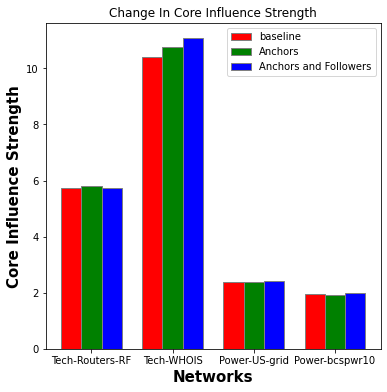

In [91]:
barWidth = 0.25
fig = plt.subplots(figsize =(6,6))
 
# set height of bar
Baseline = [5.7264, 10.4064, 2.3676, 1.9575]
Anchors = [5.8019, 10.7674 , 2.3814, 1.9120]
AnchorsandF = [5.7264, 11.0775, 2.4155,  1.9847]
 
# Set position of bar on X axis
br1 = np.arange(len(Baseline))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Baseline, color ='r', width = barWidth,
        edgecolor ='grey', label ='baseline')
plt.bar(br2, Anchors, color ='g', width = barWidth,
        edgecolor ='grey', label ='Anchors')
plt.bar(br3, AnchorsandF, color ='b', width = barWidth,
        edgecolor ='grey', label ='Anchors and Followers')
 
# Adding Xticks
plt.xlabel('Networks', fontweight ='bold', fontsize = 15)
plt.ylabel('Core Influence Strength', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Baseline))],
        ['Tech-Routers-RF', 'Tech-WHOIS', 'Power-US-grid', 'Power-bcspwr10'])
plt.title('Change In Core Influence Strength')
plt.legend()
plt.show()

Edge Resilience

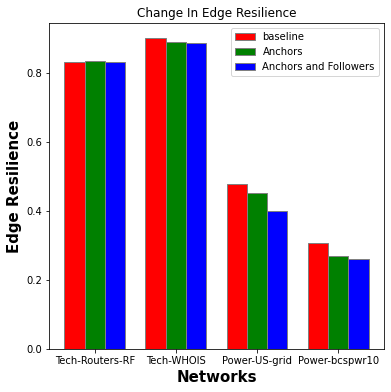

In [92]:
barWidth = 0.25
fig = plt.subplots(figsize =(6,6))
 
# set height of bar
Baseline = [0.8304, 0.8995, 0.4765, 0.3050]
Anchors = [0.8348, 0.8879 , 0.4522, 0.2679]
AnchorsandF = [0.8317, 0.8858, 0.3990,  0.2611]
 
# Set position of bar on X axis
br1 = np.arange(len(Baseline))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Baseline, color ='r', width = barWidth,
        edgecolor ='grey', label ='baseline')
plt.bar(br2, Anchors, color ='g', width = barWidth,
        edgecolor ='grey', label ='Anchors')
plt.bar(br3, AnchorsandF, color ='b', width = barWidth,
        edgecolor ='grey', label ='Anchors and Followers')
 
# Adding Xticks
plt.xlabel('Networks', fontweight ='bold', fontsize = 15)
plt.ylabel('Edge Resilience', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Baseline))],
        ['Tech-Routers-RF', 'Tech-WHOIS', 'Power-US-grid', 'Power-bcspwr10'])
plt.title('Change In Edge Resilience')
plt.legend()
plt.show()

Node Resilience

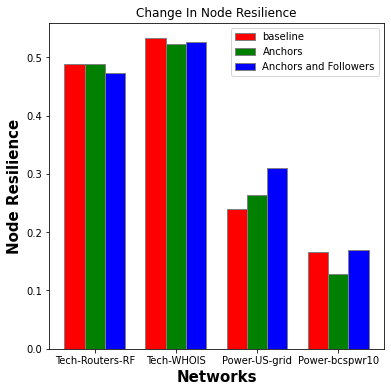

In [93]:
barWidth = 0.25
fig = plt.subplots(figsize =(6,6))
 
# set height of bar
Baseline = [0.4875, 0.5326, 0.2400, 0.1658]
Anchors = [0.4889, 0.5225 , 0.2642, 0.1287]
AnchorsandF = [0.4728, 0.5255, 0.3107,  0.1702]
 
# Set position of bar on X axis
br1 = np.arange(len(Baseline))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Baseline, color ='r', width = barWidth,
        edgecolor ='grey', label ='baseline')
plt.bar(br2, Anchors, color ='g', width = barWidth,
        edgecolor ='grey', label ='Anchors')
plt.bar(br3, AnchorsandF, color ='b', width = barWidth,
        edgecolor ='grey', label ='Anchors and Followers')
 
# Adding Xticks
plt.xlabel('Networks', fontweight ='bold', fontsize = 15)
plt.ylabel('Node Resilience', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Baseline))],
        ['Tech-Routers-RF', 'Tech-WHOIS', 'Power-US-grid', 'Power-bcspwr10'])
plt.title('Change In Node Resilience')
plt.legend()
plt.show()

# code demo